<a href="https://colab.research.google.com/github/jaya01092005/HIV-Drug-Resistance-Prediction/blob/main/PI_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io

In [ ]:
class HIVDrugResistanceDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            sequences,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
            add_special_tokens=True
        )
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def process_resistance_data(df):
    """
    Enhanced data processing with handling for rare classes
    """
    sequences = []
    for _, row in df.iterrows():
        # Extract mutation list from the last column
        mutation_pattern = row['CompMutList']

        if pd.isna(mutation_pattern) or mutation_pattern == '-':
            sequences.append("WILDTYPE NO_MUTATIONS SUSCEPTIBLE")
        else:
            mutations = mutation_pattern.split(", ")
            mutations = [f"RT_{mut}" for mut in mutations]
            mutations_with_context = []
            for mut in mutations:
                position = ''.join(filter(str.isdigit, mut))
                mutations_with_context.append(f"{mut} POS_{position}")
            sequences.append(" ".join(mutations_with_context))

    # Define drugs based on the columns in the dataset
    drugs = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV']
    labels = []
    valid_samples_mask = []  # Track which samples to keep

    # First pass to count classes for each drug
    drug_class_counts = {drug: {0: 0, 1: 0} for drug in drugs}
    for _, row in df.iterrows():
        for drug in drugs:
            if pd.isna(row[drug]) or row[drug] == 'NA':
                drug_class_counts[drug][0] += 1
            else:
                fold_value = float(row[drug])
                label = 1 if fold_value > 3.5 else 0
                drug_class_counts[drug][label] += 1

    # Print class distribution before filtering
    print("Class distribution before filtering:")
    for drug in drugs:
        print(f"\n{drug}:")
        print(f"Class 0 (non-resistant): {drug_class_counts[drug][0]}")
        print(f"Class 1 (resistant): {drug_class_counts[drug][1]}")

    # Second pass to create labels, excluding samples with rare classes
    for _, row in df.iterrows():
        drug_labels = []
        valid_sample = True

        for drug in drugs:
            if pd.isna(row[drug]) or row[drug] == 'NA':
                label = 0
            else:
                fold_value = float(row[drug])
                label = 1 if fold_value > 3.5 else 0

            # Check if this class is rare for this drug
            #if drug_class_counts[drug][label] < 2:
                #valid_sample = False
                #break

            drug_labels.append(label)

        labels.append(drug_labels)
        valid_samples_mask.append(True)

    # Filter sequences to match valid labels
    sequences = [seq for seq, mask in zip(sequences, valid_samples_mask) if mask]

    # Print final class distribution
    print("\nClass distribution after filtering rare classes:")
    filtered_df = df[valid_samples_mask]
    for drug in drugs:
        resistant_count = sum(1 for _, row in filtered_df.iterrows()
                            if not pd.isna(row[drug]) and row[drug] != 'NA' and float(row[drug]) > 10)
        non_resistant_count = len(filtered_df) - resistant_count
        print(f"\n{drug}:")
        print(f"Class 0 (non-resistant): {non_resistant_count}")
        print(f"Class 1 (resistant): {resistant_count}")

    return sequences, labels

In [ ]:
def upload_and_process_file():
    """
    Handle file upload in Google Colab and process the data
    """
    print("Please upload your resistance data file...")
    uploaded = files.upload()

    file_name = list(uploaded.keys())[0]
    content = uploaded[file_name]

    if file_name.endswith('.txt'):
        df = pd.read_csv(io.BytesIO(content), sep='\t')
    else:
        raise ValueError("Please upload a tab-separated txt file")

    return df

In [ ]:
def calculate_metrics(predictions, true_labels):
    """
    Calculate various metrics for model evaluation
    """
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels.flatten(), predictions.flatten(), average="binary")
    accuracy = accuracy_score(true_labels.flatten(), predictions.flatten())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels.flatten(), predictions.flatten())
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "specificity": specificity,
        "npv": npv,
        "confusion_matrix": {
            "true_positives": int(tp),
            "true_negatives": int(tn),
            "false_positives": int(fp),
            "false_negatives": int(fn)
        }
    }

    return metrics, conf_matrix

In [ ]:
def plot_confusion_matrix(conf_matrix):
    """
    Plot a confusion matrix as a heatmap
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Negative", "Predicted Positive"],
        yticklabels=["Actual Negative", "Actual Positive"]
    )
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def print_metrics(metrics):
    """
    Print formatted metrics and confusion matrix elements
    """
    print("\nValidation Metrics:")
    print("-" * 40)

    for metric, value in metrics.items():
        if metric != "confusion_matrix":
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    print("\nConfusion Matrix Elements:")
    for key, value in metrics["confusion_matrix"].items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    print("-" * 40)

In [ ]:
def get_warmup_steps(config, num_training_steps):
    """Calculate warmup steps based on either direct steps or ratio"""
    if 'warmup_steps' in config:
        return config['warmup_steps']
    elif 'warmup_ratio' in config:
        return int(num_training_steps * config['warmup_ratio'])
    else:
        # Default to 10% if neither is specified
        return int(num_training_steps * 0.1)

In [ ]:
def train_model(train_dataset, val_dataset, model, device, config):
    """
    Enhanced training function with better optimization and monitoring
    """
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Initialize optimizer with weight decay
    optimizer = AdamW(model.parameters(),
                     lr=config['learning_rate'],
                     weight_decay=config['weight_decay'])

    # Calculate total training steps and warmup steps
    num_training_steps = len(train_loader) * config['num_epochs']
    warmup_steps = get_warmup_steps(config, num_training_steps)

    print(f"Total training steps: {num_training_steps}")
    print(f"Warmup steps: {warmup_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )

    best_val_loss = float("inf")
    patience = config['patience']
    patience_counter = 0
    training_stats = []

    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        steps = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Add L1 regularization if specified
            if 'l1_lambda' in config:
                l1_lambda = config['l1_lambda']
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            total_loss += loss.item()
            steps += 1

            loss.backward()

            # Gradient clipping
            if 'max_grad_norm' in config:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / steps

        # Validation phase
        model.eval()
        val_loss = 0
        y_true_all, y_scores_all = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                logits = outputs.logits
                probabilities = torch.sigmoid(logits).cpu().numpy()
                y_scores_all.extend(probabilities)
                y_true_all.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)

        # Generate PR Curves for Each Drug
        y_true_all = np.array(y_true_all)
        y_scores_all = np.array(y_scores_all)
        num_drugs = y_true_all.shape[1]


        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        for i in range(num_drugs):
            precision, recall, _ = precision_recall_curve(y_true_all[:, i], y_scores_all[:, i])
            pr_auc = auc(recall, precision)
            plt.figure()
            plt.plot(recall, precision, color=colors[i % len(colors)])
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve for Drug {i + 1}")
            #plt.legend()
            plt.grid(False)
            plt.show()

            print(f"PR-AUC for Drug {i + 1}: {pr_auc:.4f}")

        # Calculate and print metrics
        predictions = (np.array(y_scores_all) > 0.5).astype(int)
        metrics, conf_matrix = calculate_metrics(predictions, y_true_all)
        current_lr = scheduler.get_last_lr()[0]

        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print_metrics(metrics)
        plot_confusion_matrix(conf_matrix)

        # Save training stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'learning_rate': current_lr,
            **metrics
        })

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            model.save_pretrained("best_hiv_resistance_model")
            print("Saved best model!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return model, training_stats

Using device: cuda
Loading model and tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please upload your resistance data file...


Saving PI_DataSet.txt to PI_DataSet.txt
Class distribution before filtering:

FPV:
Class 0 (non-resistant): 1449
Class 1 (resistant): 946

ATV:
Class 0 (non-resistant): 1528
Class 1 (resistant): 867

IDV:
Class 0 (non-resistant): 1257
Class 1 (resistant): 1138

LPV:
Class 0 (non-resistant): 1356
Class 1 (resistant): 1039

NFV:
Class 0 (non-resistant): 1062
Class 1 (resistant): 1333

SQV:
Class 0 (non-resistant): 1431
Class 1 (resistant): 964

TPV:
Class 0 (non-resistant): 2086
Class 1 (resistant): 309

DRV:
Class 0 (non-resistant): 2058
Class 1 (resistant): 337

Class distribution after filtering rare classes:

FPV:
Class 0 (non-resistant): 1763
Class 1 (resistant): 632

ATV:
Class 0 (non-resistant): 1719
Class 1 (resistant): 676

IDV:
Class 0 (non-resistant): 1554
Class 1 (resistant): 841

LPV:
Class 0 (non-resistant): 1522
Class 1 (resistant): 873

NFV:
Class 0 (non-resistant): 1335
Class 1 (resistant): 1060

SQV:
Class 0 (non-resistant): 1670
Class 1 (resistant): 725

TPV:
Class 0 (

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total training steps: 4800
Warmup steps: 720


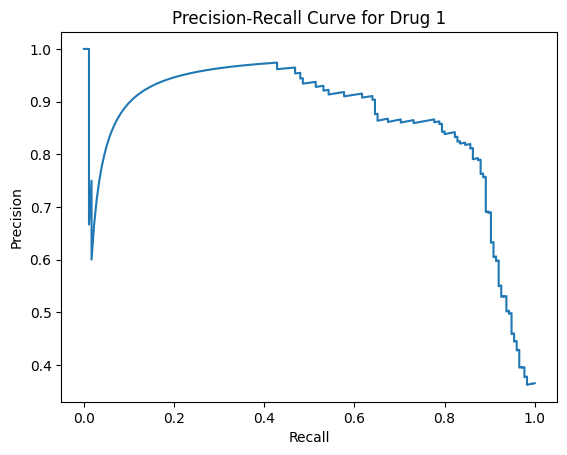

PR-AUC for Drug 1: 0.8587


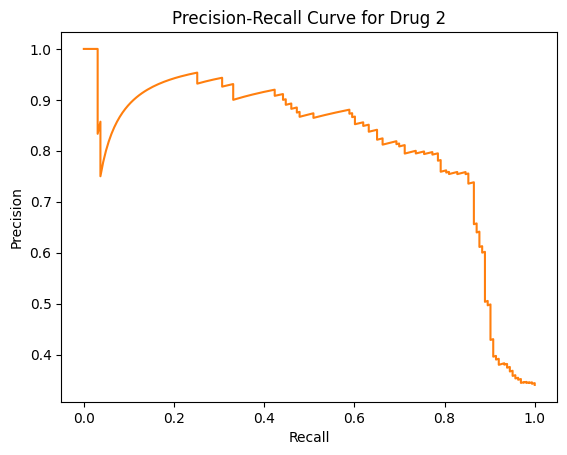

PR-AUC for Drug 2: 0.8129


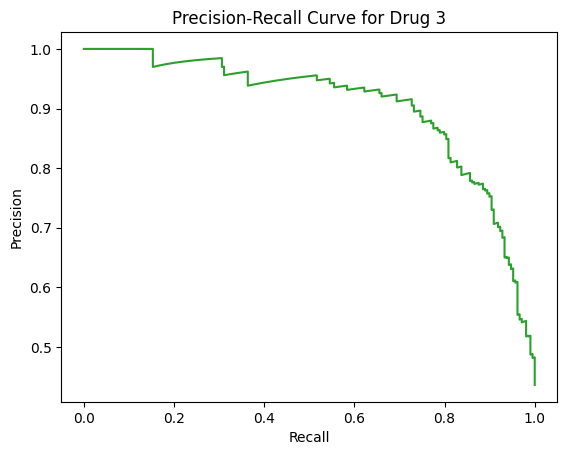

PR-AUC for Drug 3: 0.9040


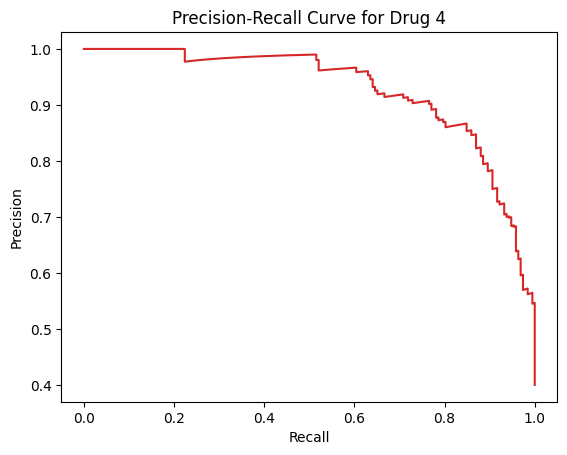

PR-AUC for Drug 4: 0.9272


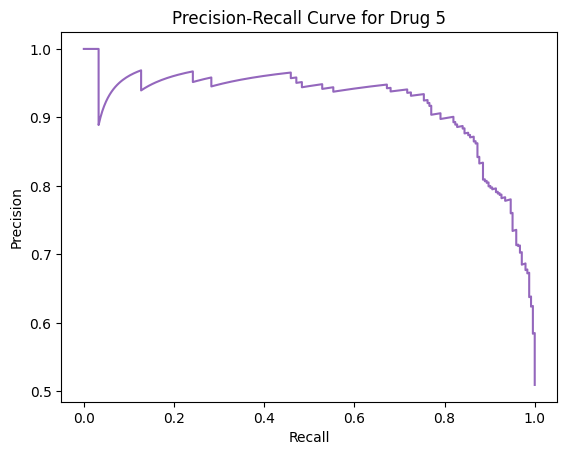

PR-AUC for Drug 5: 0.9194


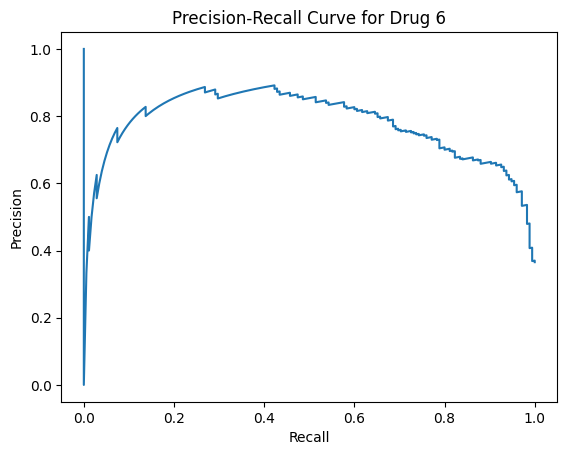

PR-AUC for Drug 6: 0.7697


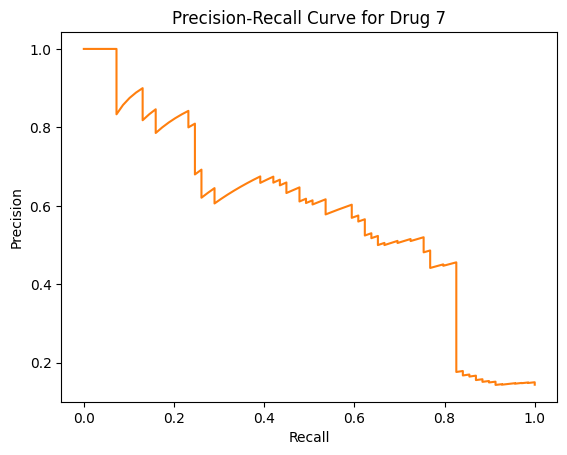

PR-AUC for Drug 7: 0.5814


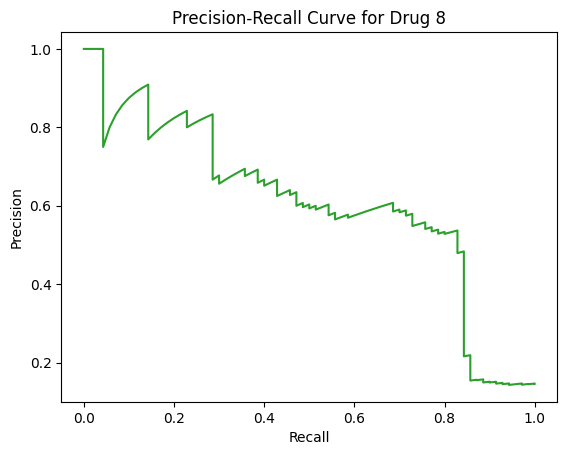

PR-AUC for Drug 8: 0.6042

Epoch 1/20
Training Loss: 0.5961
Validation Loss: 0.4330
Learning Rate: 3.33e-06

Validation Metrics:
----------------------------------------
Precision: 0.8708
Recall: 0.6546
F1 Score: 0.7474
Accuracy: 0.8502
Specificity: 0.9503
Npv: 0.8432

Confusion Matrix Elements:
True Positives: 849
True Negatives: 2409
False Positives: 126
False Negatives: 448
----------------------------------------


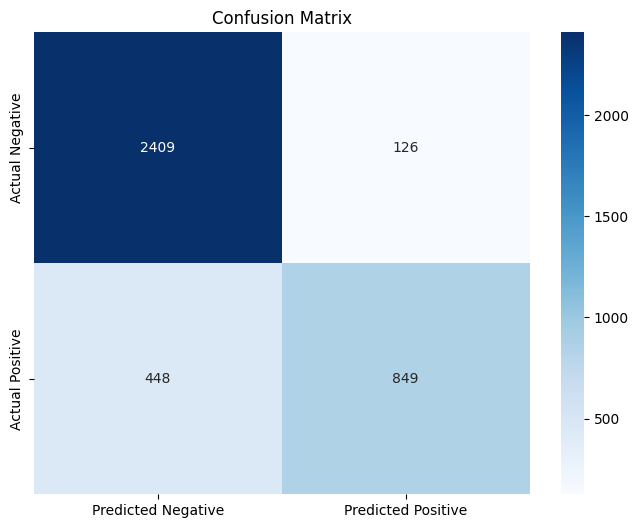

Saved best model!


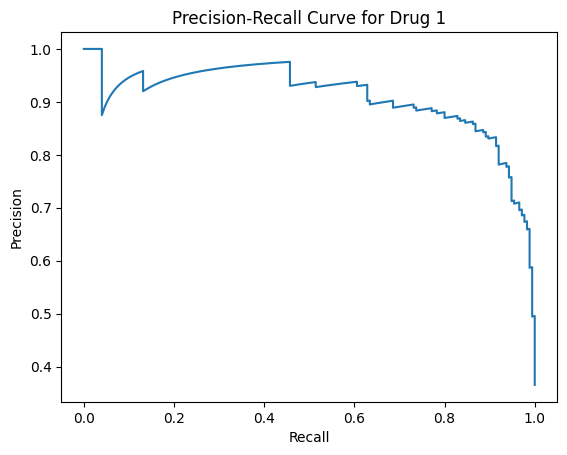

PR-AUC for Drug 1: 0.9085


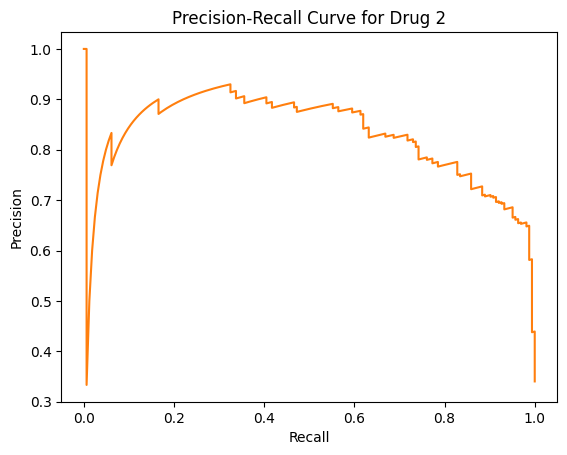

PR-AUC for Drug 2: 0.8257


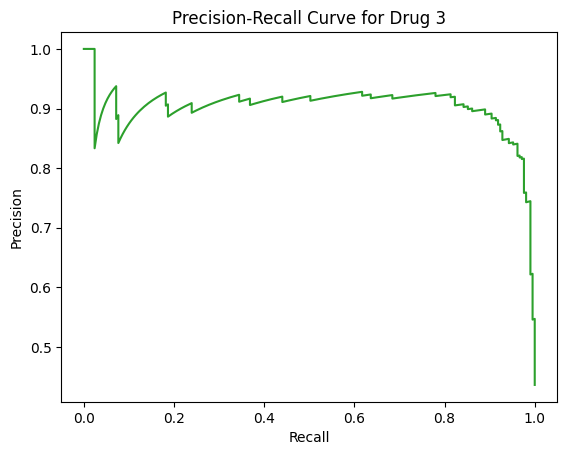

PR-AUC for Drug 3: 0.9031


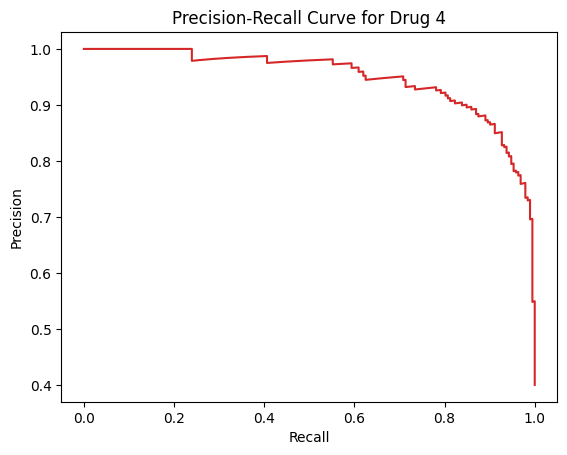

PR-AUC for Drug 4: 0.9493


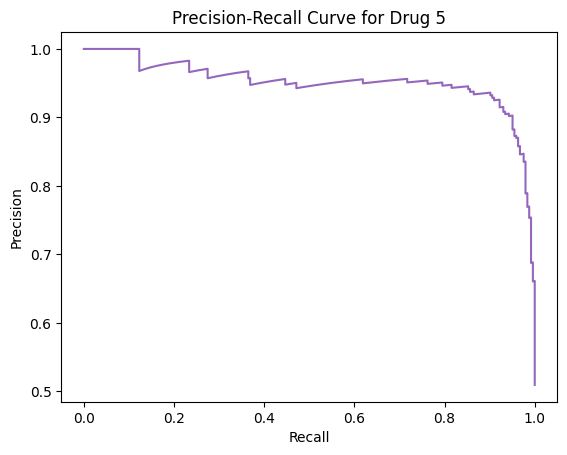

PR-AUC for Drug 5: 0.9518


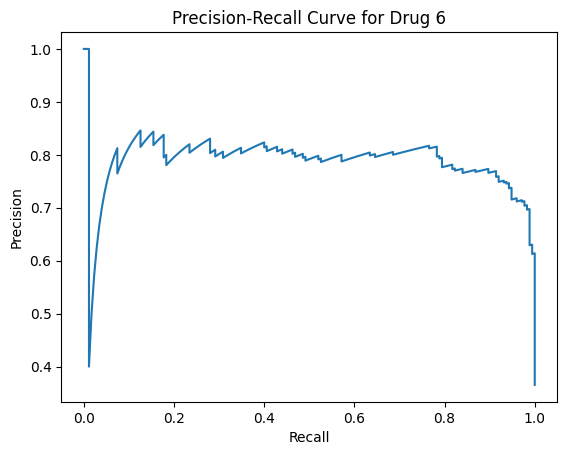

PR-AUC for Drug 6: 0.7887


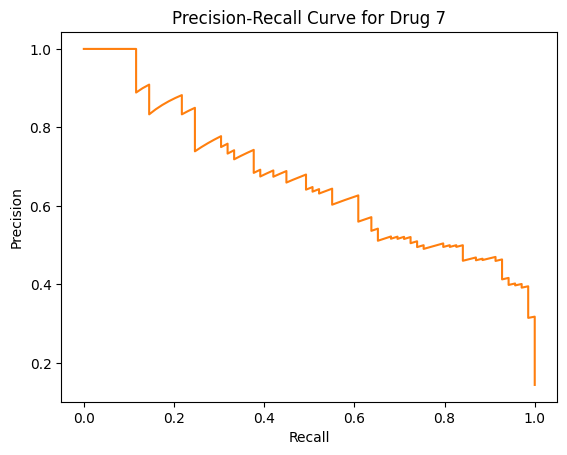

PR-AUC for Drug 7: 0.6655


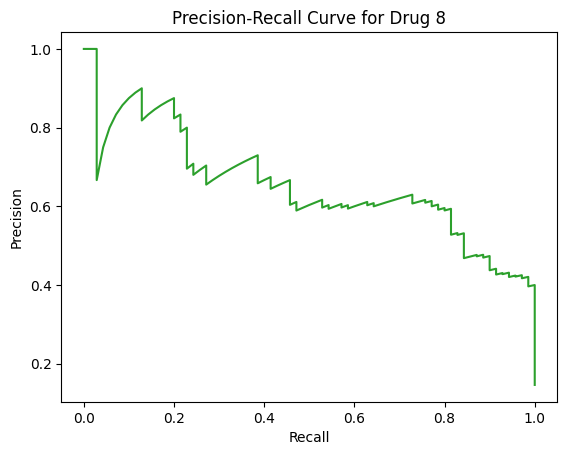

PR-AUC for Drug 8: 0.6524

Epoch 2/20
Training Loss: 0.3981
Validation Loss: 0.3243
Learning Rate: 6.67e-06

Validation Metrics:
----------------------------------------
Precision: 0.7734
Recall: 0.8998
F1 Score: 0.8318
Accuracy: 0.8768
Specificity: 0.8651
Npv: 0.9440

Confusion Matrix Elements:
True Positives: 1167
True Negatives: 2193
False Positives: 342
False Negatives: 130
----------------------------------------


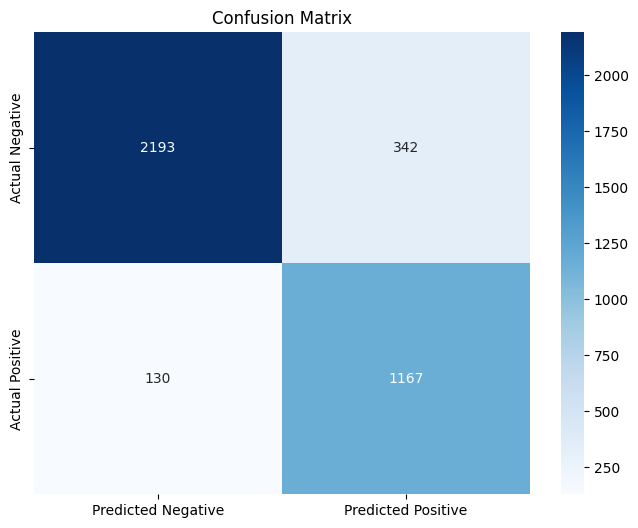

Saved best model!


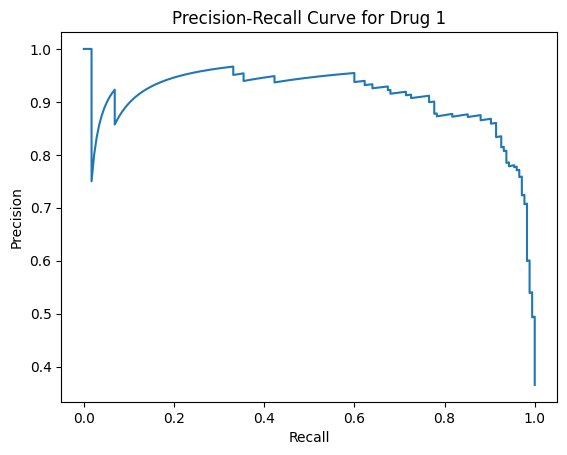

PR-AUC for Drug 1: 0.9077


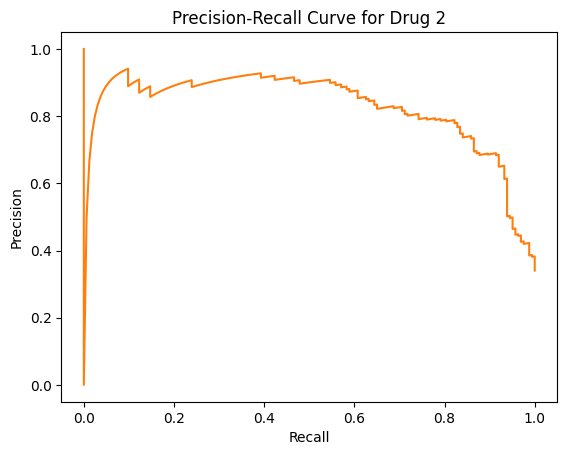

PR-AUC for Drug 2: 0.8223


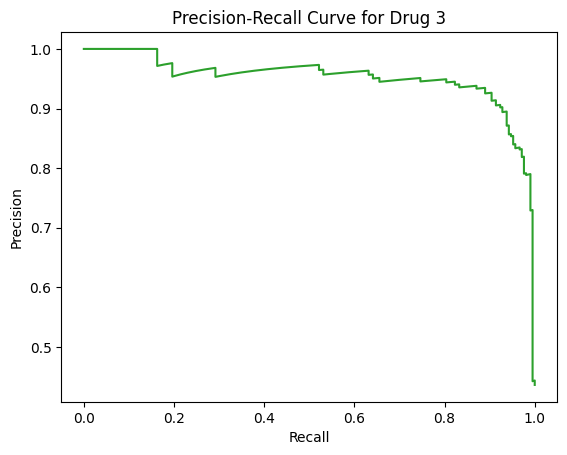

PR-AUC for Drug 3: 0.9517


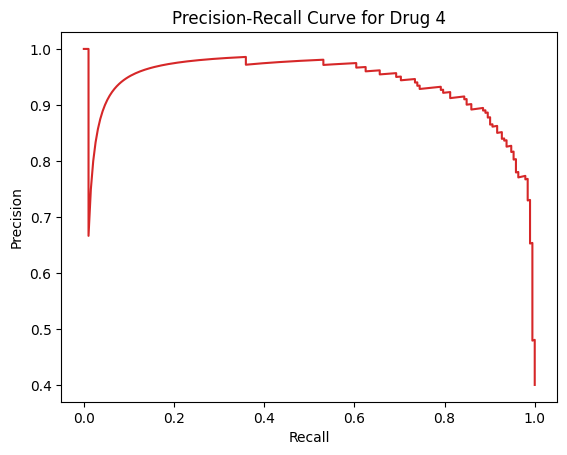

PR-AUC for Drug 4: 0.9366


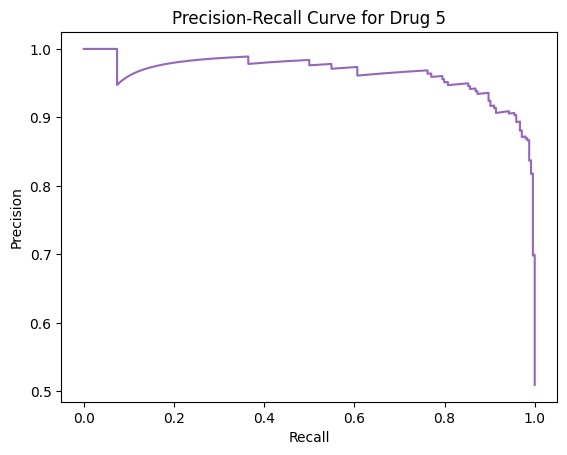

PR-AUC for Drug 5: 0.9643


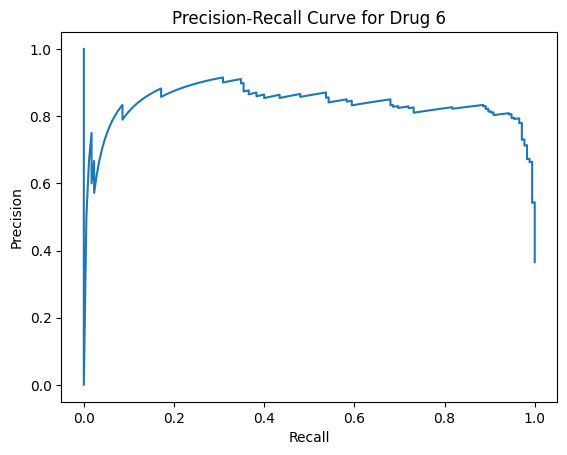

PR-AUC for Drug 6: 0.8308


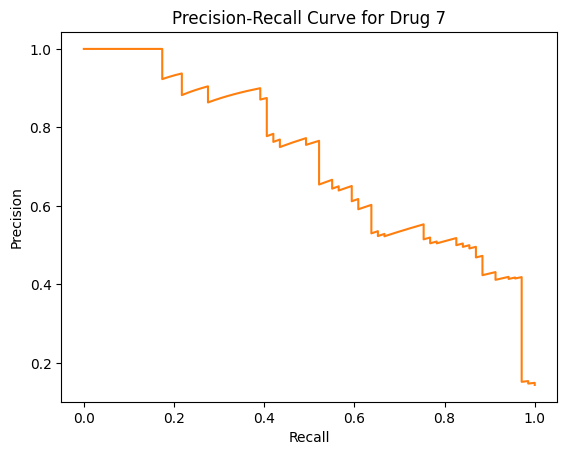

PR-AUC for Drug 7: 0.7120


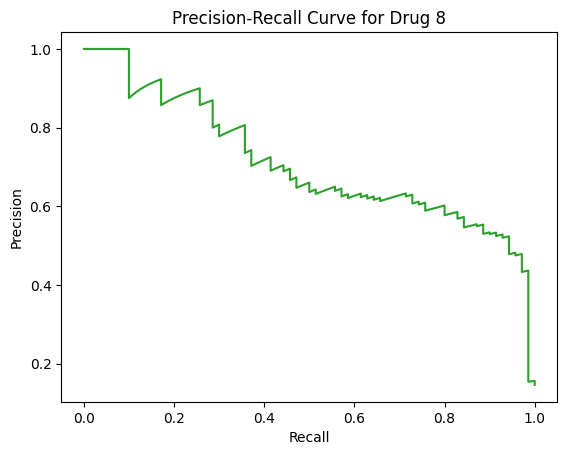

PR-AUC for Drug 8: 0.7082

Epoch 3/20
Training Loss: 0.3334
Validation Loss: 0.2722
Learning Rate: 1.00e-05

Validation Metrics:
----------------------------------------
Precision: 0.8519
Recall: 0.8427
F1 Score: 0.8473
Accuracy: 0.8972
Specificity: 0.9250
Npv: 0.9200

Confusion Matrix Elements:
True Positives: 1093
True Negatives: 2345
False Positives: 190
False Negatives: 204
----------------------------------------


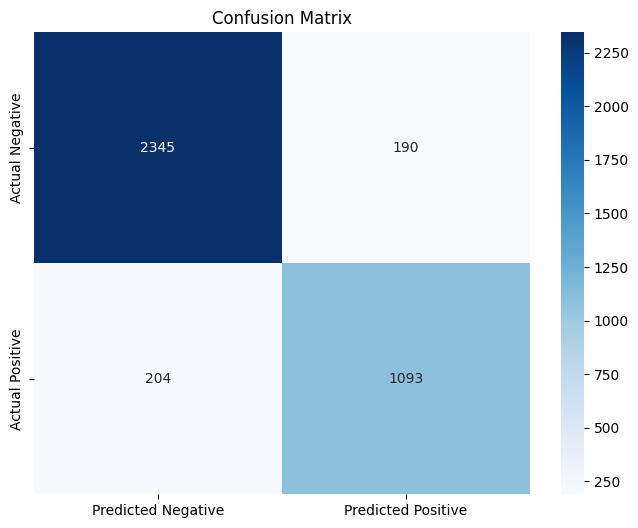

Saved best model!


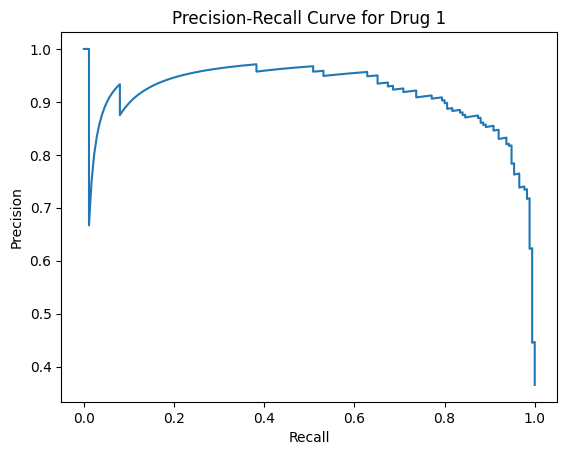

PR-AUC for Drug 1: 0.9148


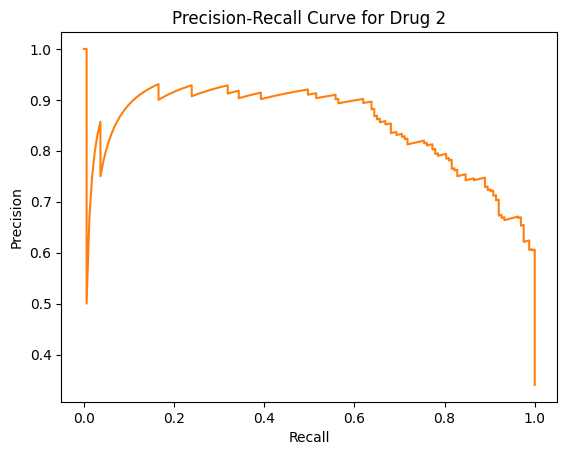

PR-AUC for Drug 2: 0.8479


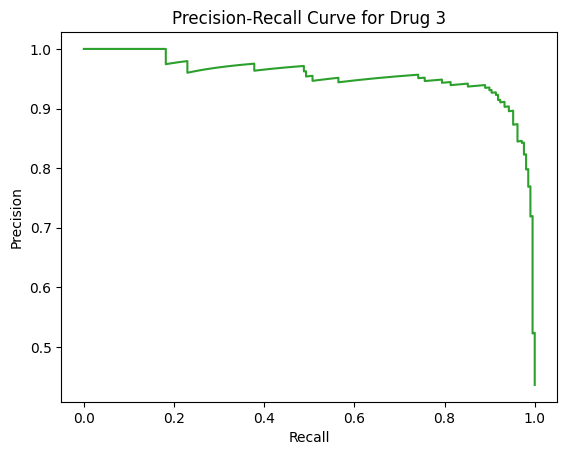

PR-AUC for Drug 3: 0.9547


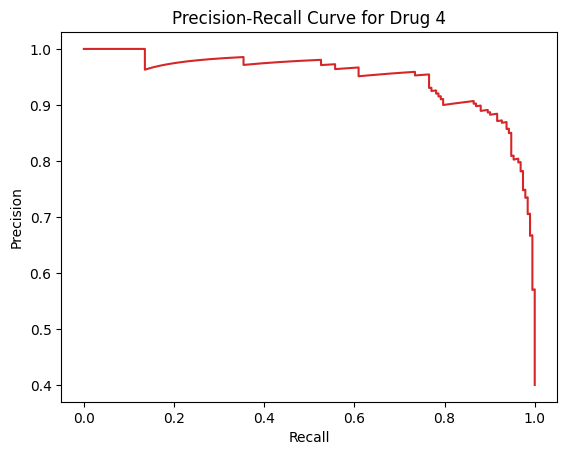

PR-AUC for Drug 4: 0.9491


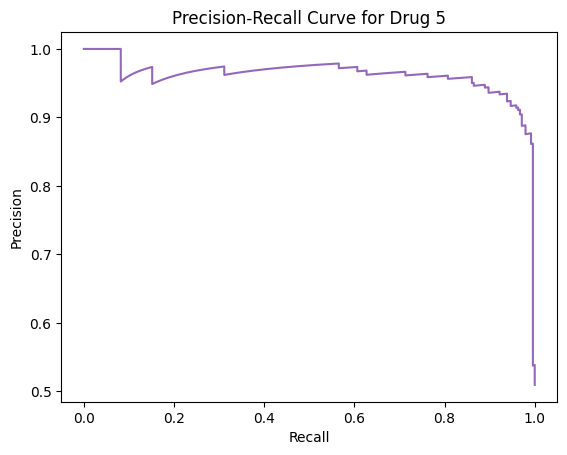

PR-AUC for Drug 5: 0.9618


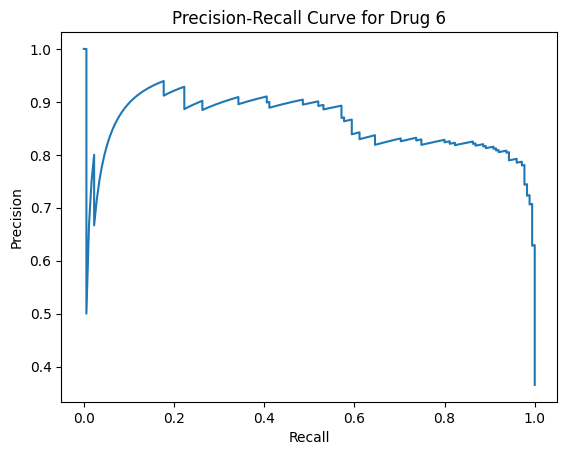

PR-AUC for Drug 6: 0.8570


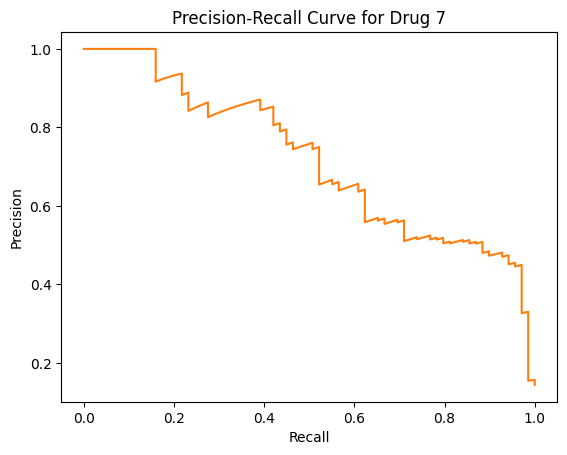

PR-AUC for Drug 7: 0.7161


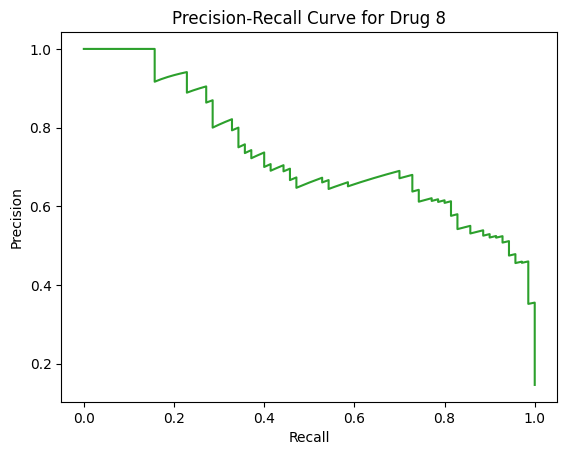

PR-AUC for Drug 8: 0.7303

Epoch 4/20
Training Loss: 0.2971
Validation Loss: 0.2449
Learning Rate: 9.41e-06

Validation Metrics:
----------------------------------------
Precision: 0.8254
Recall: 0.8967
F1 Score: 0.8596
Accuracy: 0.9008
Specificity: 0.9030
Npv: 0.9447

Confusion Matrix Elements:
True Positives: 1163
True Negatives: 2289
False Positives: 246
False Negatives: 134
----------------------------------------


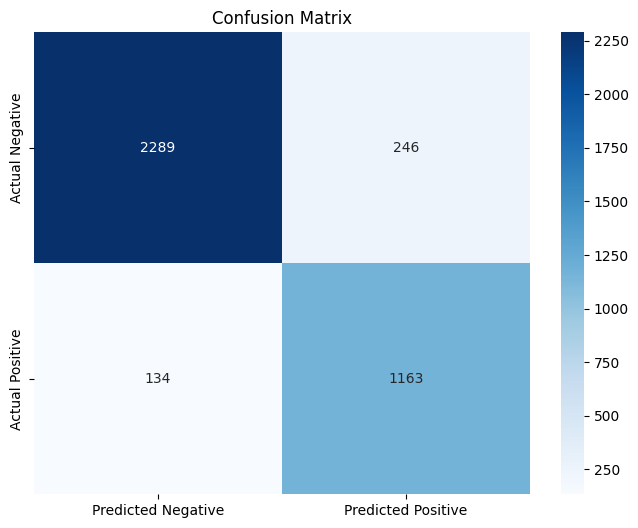

Saved best model!


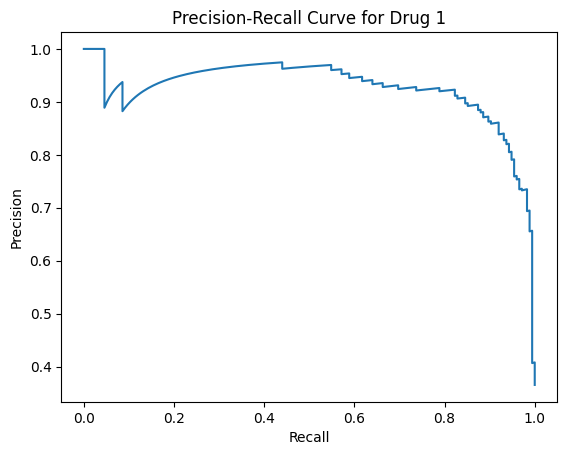

PR-AUC for Drug 1: 0.9257


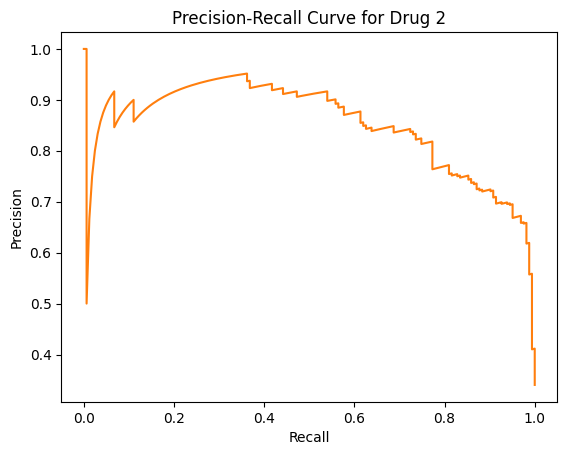

PR-AUC for Drug 2: 0.8485


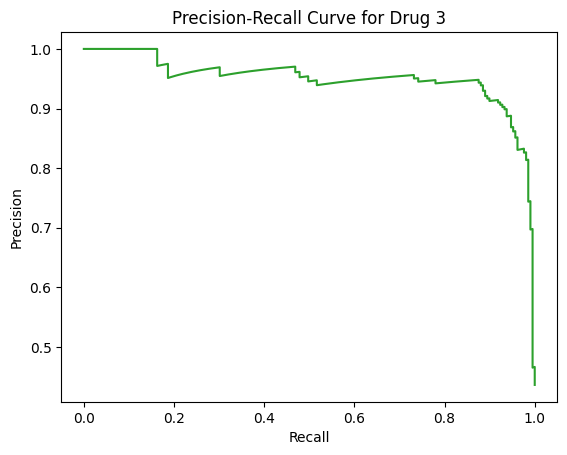

PR-AUC for Drug 3: 0.9501


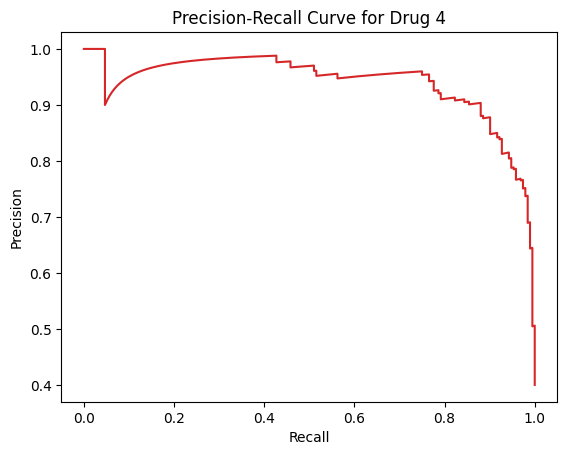

PR-AUC for Drug 4: 0.9400


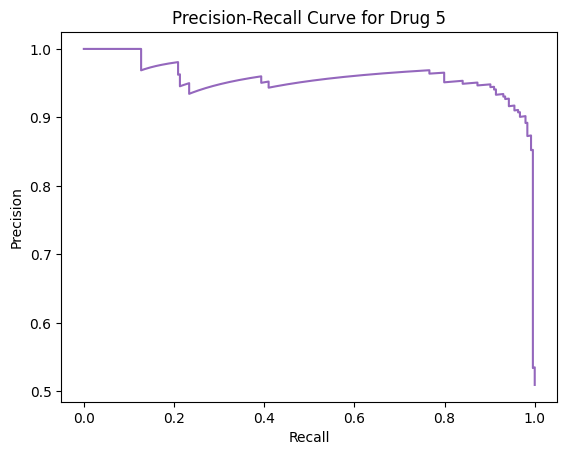

PR-AUC for Drug 5: 0.9569


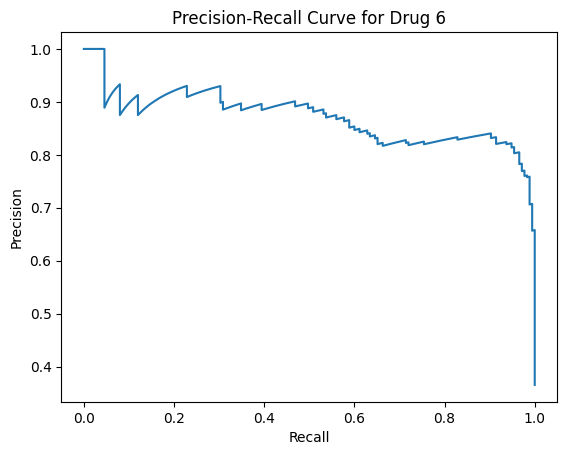

PR-AUC for Drug 6: 0.8712


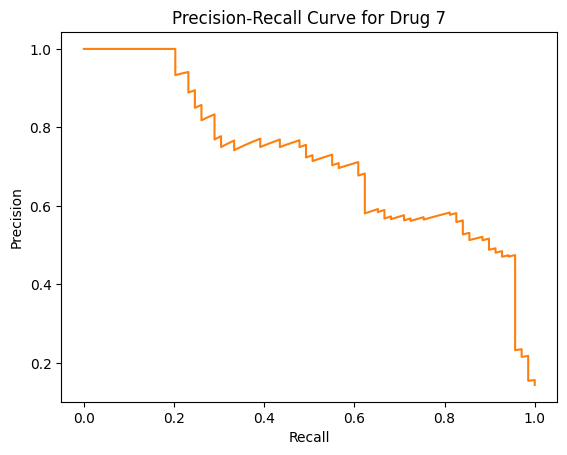

PR-AUC for Drug 7: 0.7175


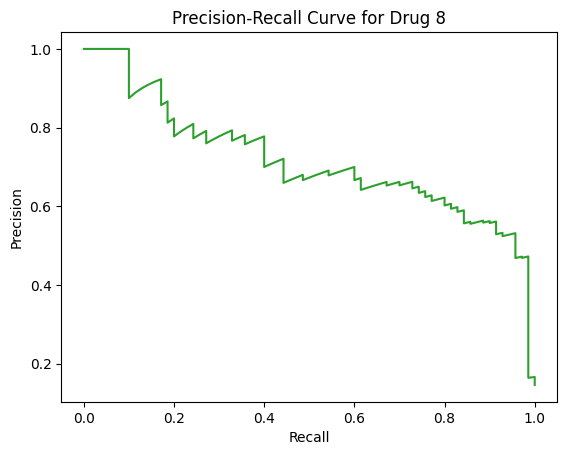

PR-AUC for Drug 8: 0.7150

Epoch 5/20
Training Loss: 0.2783
Validation Loss: 0.2500
Learning Rate: 8.82e-06

Validation Metrics:
----------------------------------------
Precision: 0.8800
Recall: 0.7972
F1 Score: 0.8366
Accuracy: 0.8946
Specificity: 0.9444
Npv: 0.9010

Confusion Matrix Elements:
True Positives: 1034
True Negatives: 2394
False Positives: 141
False Negatives: 263
----------------------------------------


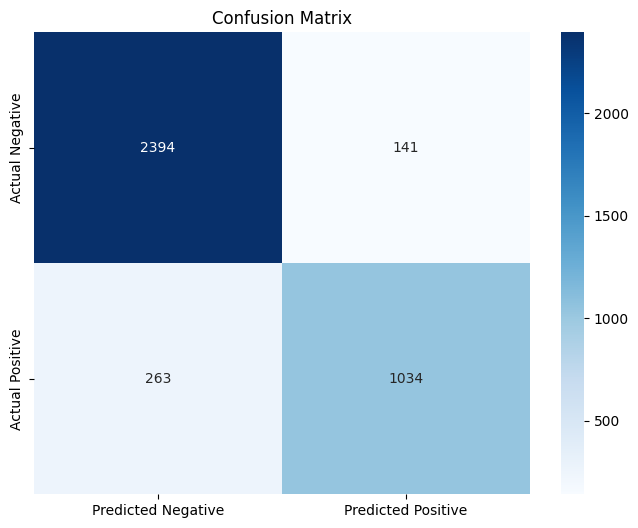

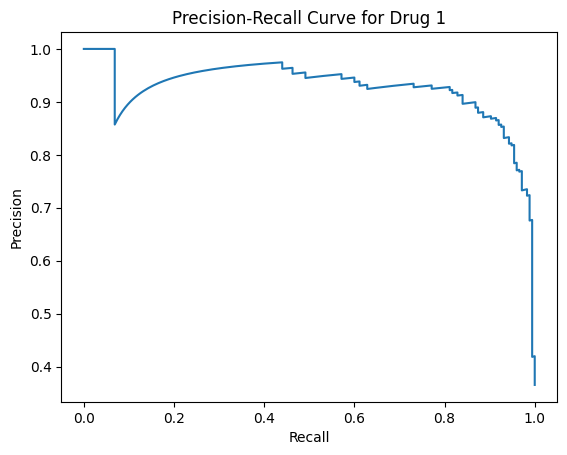

PR-AUC for Drug 1: 0.9264


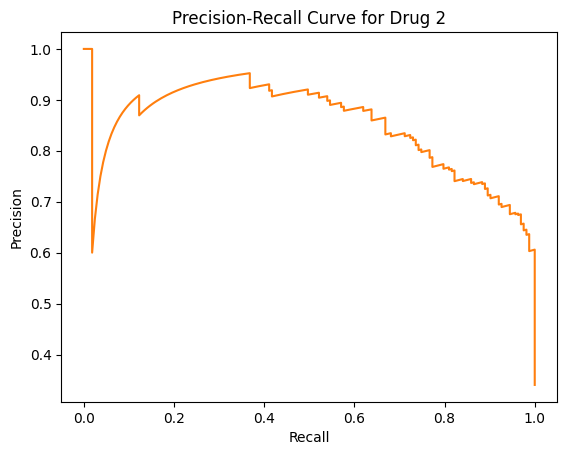

PR-AUC for Drug 2: 0.8499


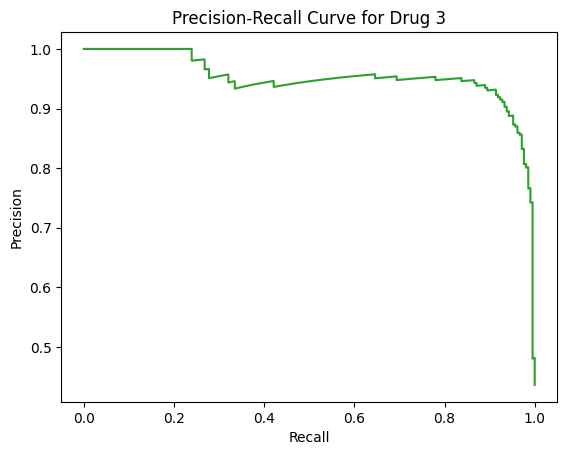

PR-AUC for Drug 3: 0.9518


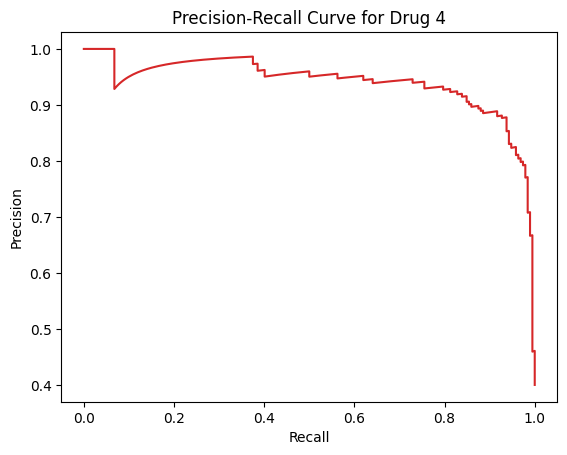

PR-AUC for Drug 4: 0.9410


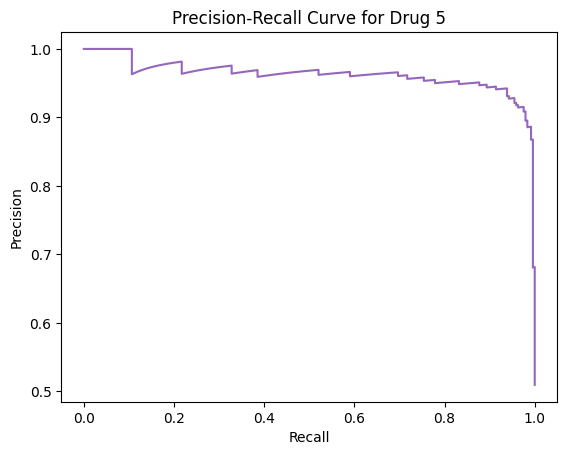

PR-AUC for Drug 5: 0.9626


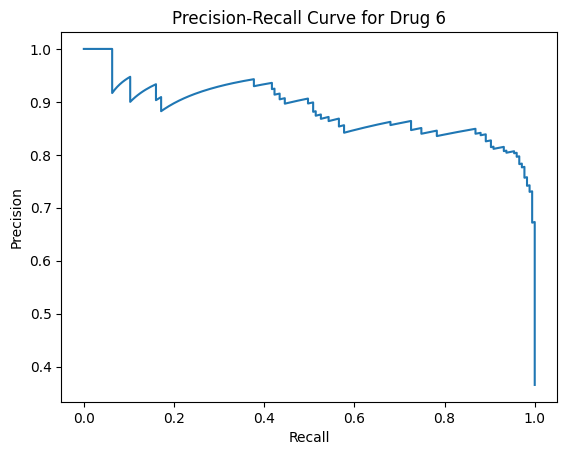

PR-AUC for Drug 6: 0.8843


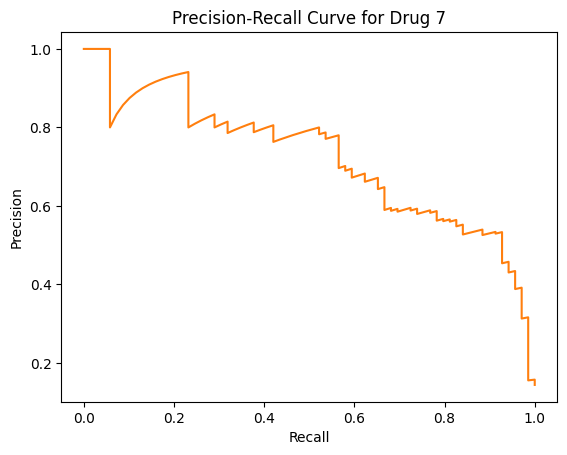

PR-AUC for Drug 7: 0.7199


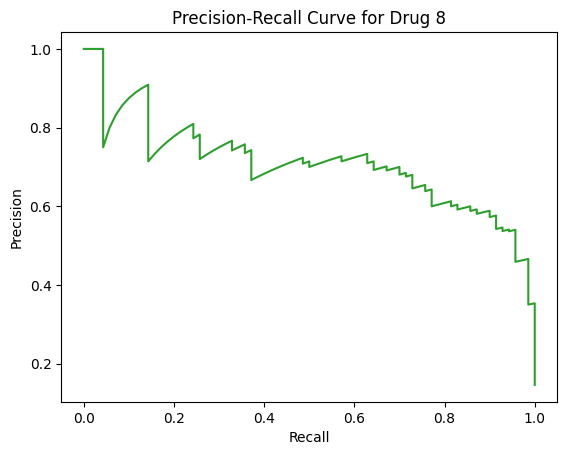

PR-AUC for Drug 8: 0.7071

Epoch 6/20
Training Loss: 0.2692
Validation Loss: 0.2342
Learning Rate: 8.24e-06

Validation Metrics:
----------------------------------------
Precision: 0.8502
Recall: 0.8620
F1 Score: 0.8560
Accuracy: 0.9019
Specificity: 0.9223
Npv: 0.9289

Confusion Matrix Elements:
True Positives: 1118
True Negatives: 2338
False Positives: 197
False Negatives: 179
----------------------------------------


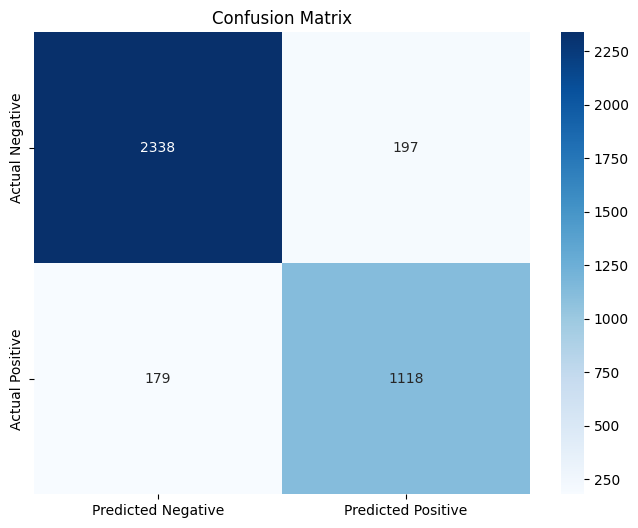

Saved best model!


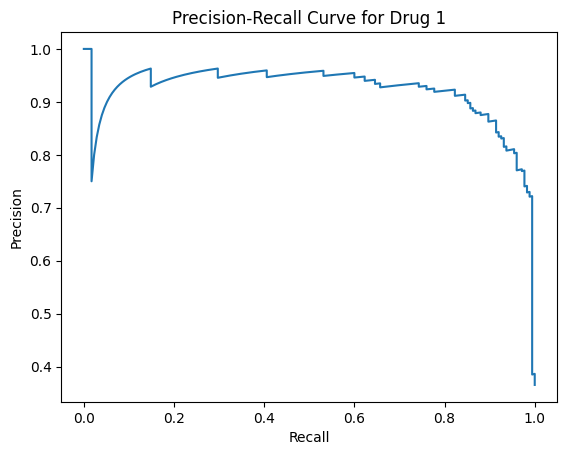

PR-AUC for Drug 1: 0.9214


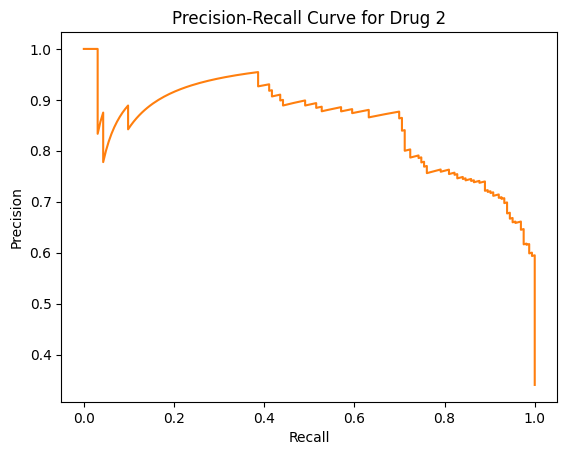

PR-AUC for Drug 2: 0.8512


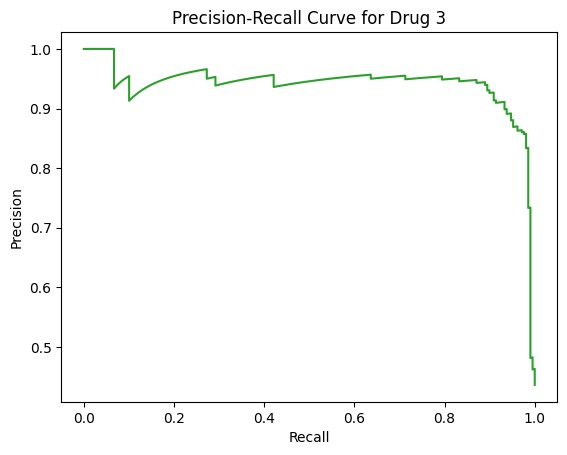

PR-AUC for Drug 3: 0.9412


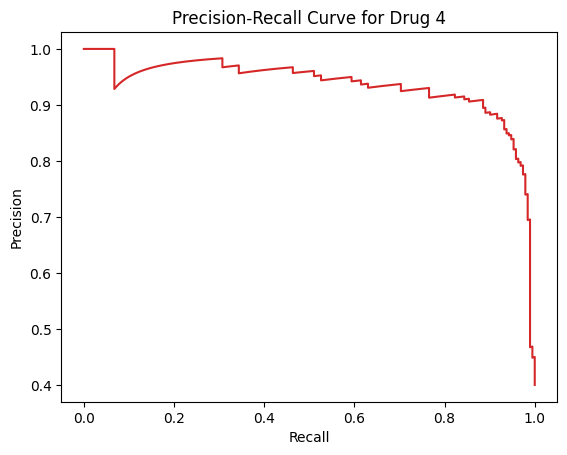

PR-AUC for Drug 4: 0.9361


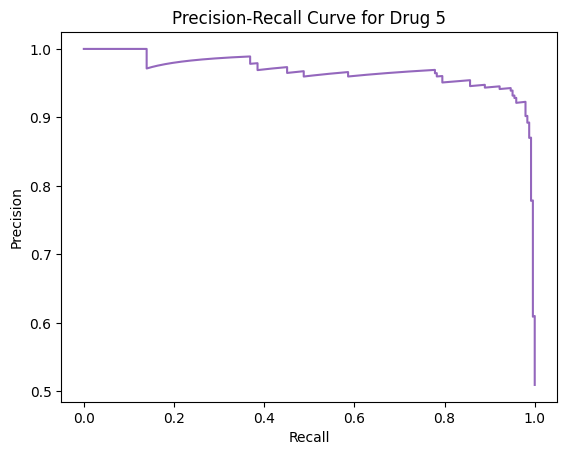

PR-AUC for Drug 5: 0.9674


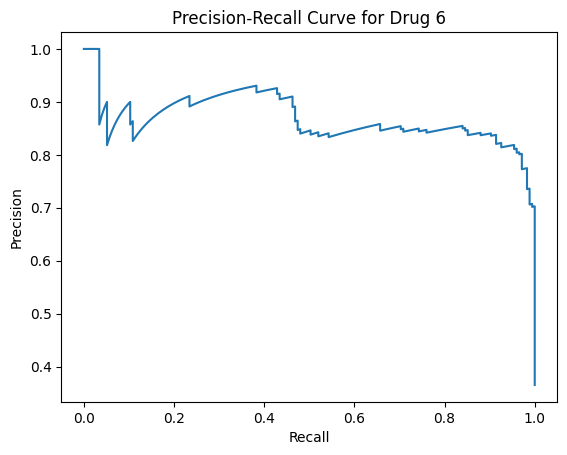

PR-AUC for Drug 6: 0.8679


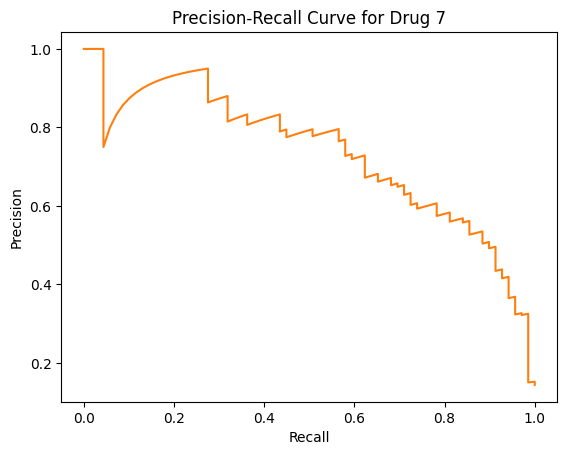

PR-AUC for Drug 7: 0.7328


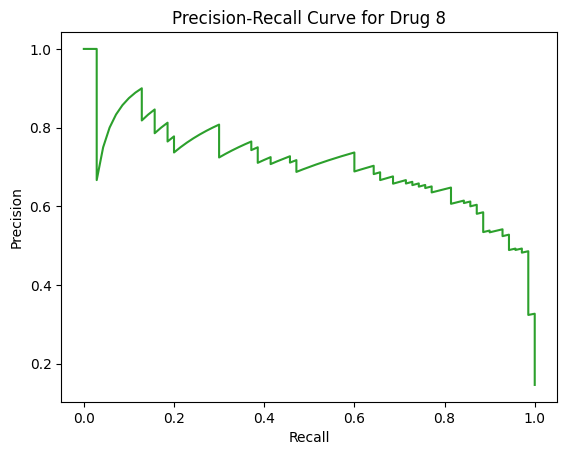

PR-AUC for Drug 8: 0.7054

Epoch 7/20
Training Loss: 0.2538
Validation Loss: 0.2326
Learning Rate: 7.65e-06

Validation Metrics:
----------------------------------------
Precision: 0.8415
Recall: 0.8921
F1 Score: 0.8660
Accuracy: 0.9066
Specificity: 0.9140
Npv: 0.9430

Confusion Matrix Elements:
True Positives: 1157
True Negatives: 2317
False Positives: 218
False Negatives: 140
----------------------------------------


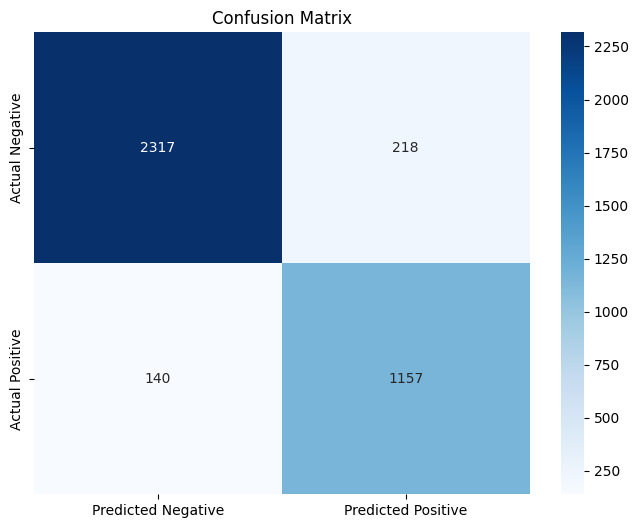

Saved best model!


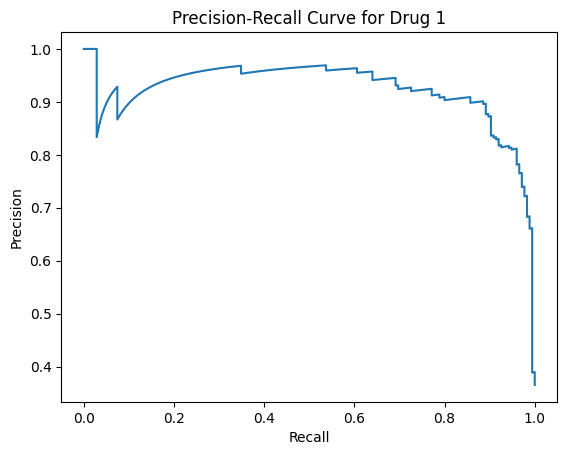

PR-AUC for Drug 1: 0.9225


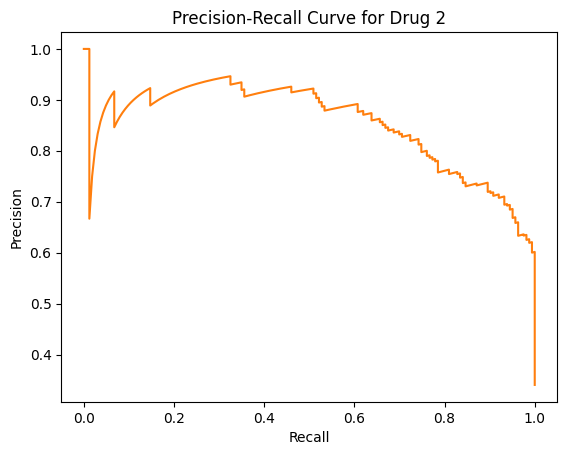

PR-AUC for Drug 2: 0.8521


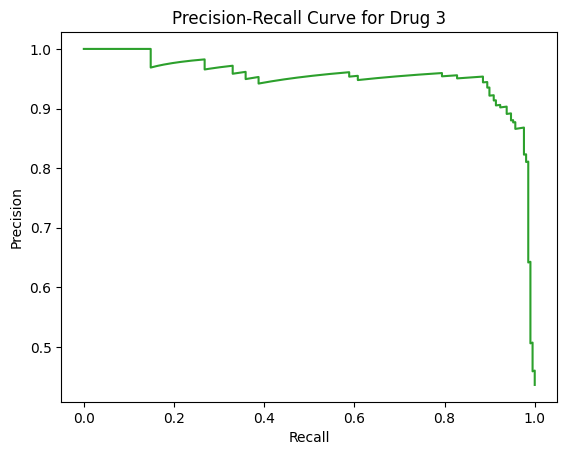

PR-AUC for Drug 3: 0.9521


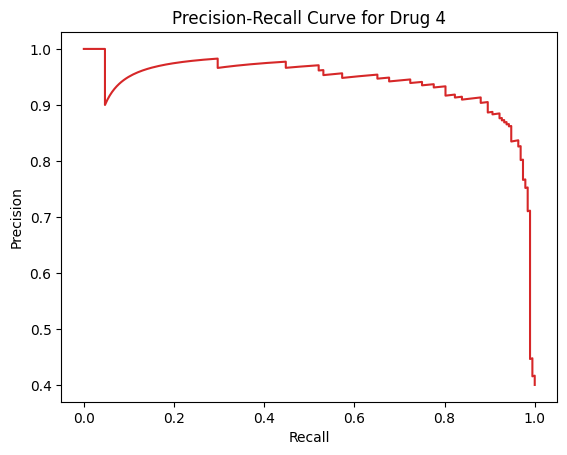

PR-AUC for Drug 4: 0.9403


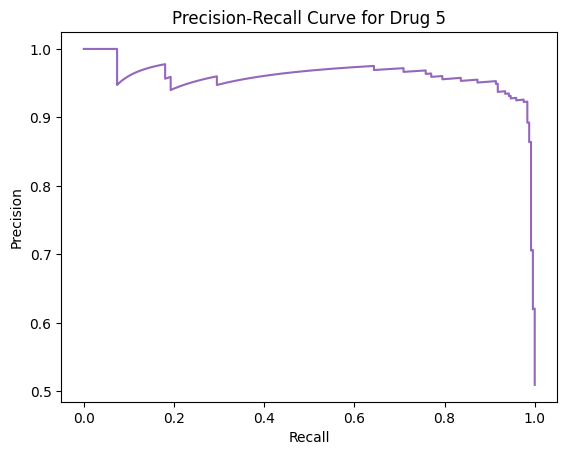

PR-AUC for Drug 5: 0.9597


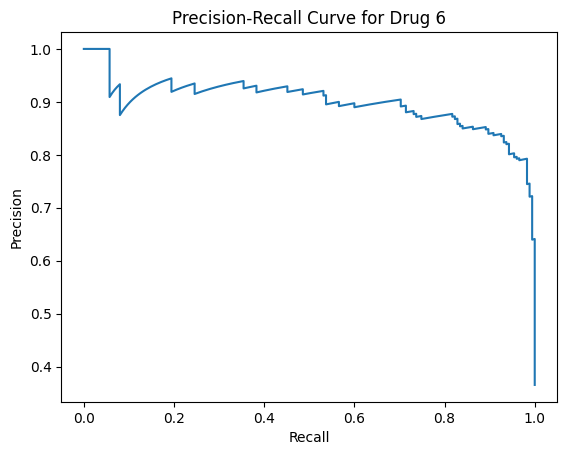

PR-AUC for Drug 6: 0.8994


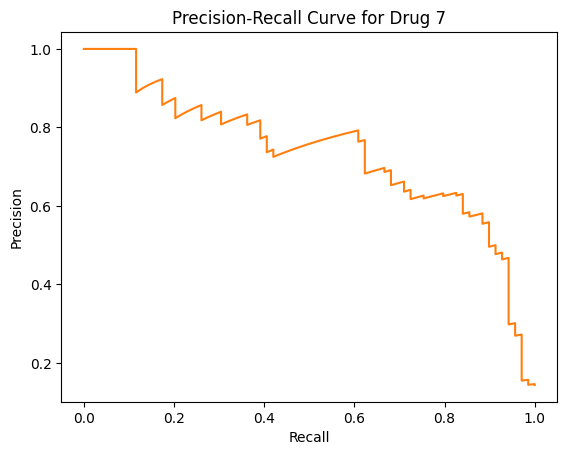

PR-AUC for Drug 7: 0.7339


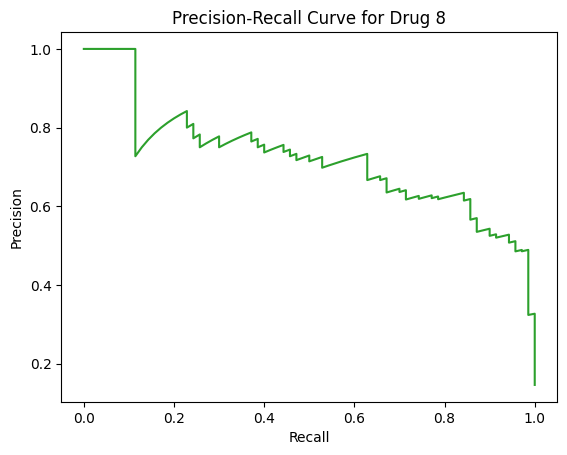

PR-AUC for Drug 8: 0.7202

Epoch 8/20
Training Loss: 0.2432
Validation Loss: 0.2434
Learning Rate: 7.06e-06

Validation Metrics:
----------------------------------------
Precision: 0.8838
Recall: 0.8150
F1 Score: 0.8480
Accuracy: 0.9011
Specificity: 0.9452
Npv: 0.9090

Confusion Matrix Elements:
True Positives: 1057
True Negatives: 2396
False Positives: 139
False Negatives: 240
----------------------------------------


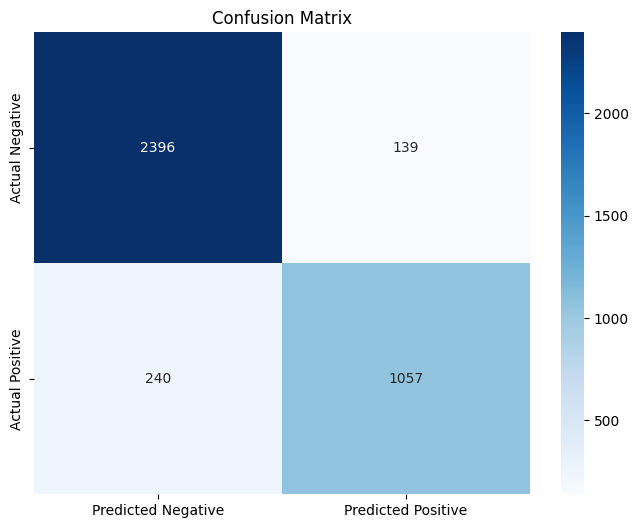

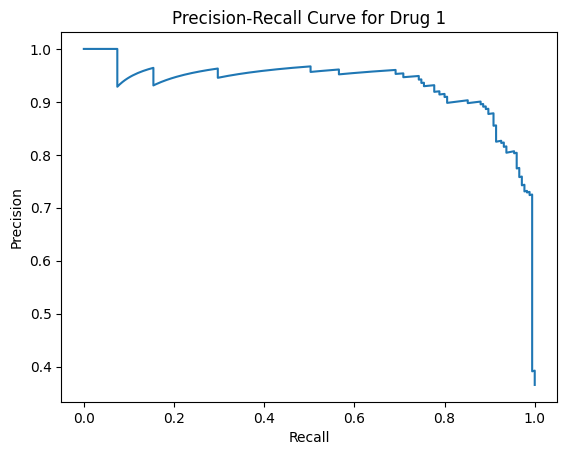

PR-AUC for Drug 1: 0.9326


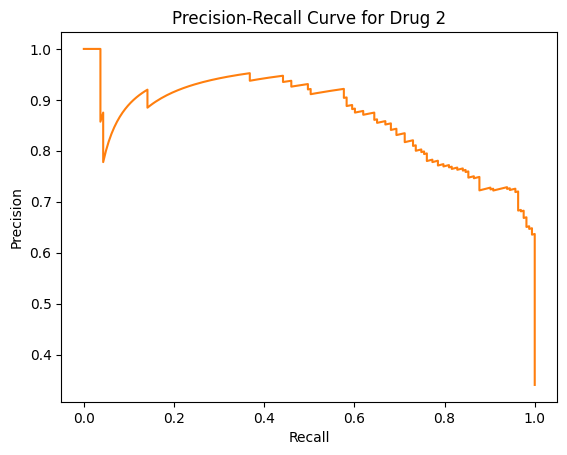

PR-AUC for Drug 2: 0.8644


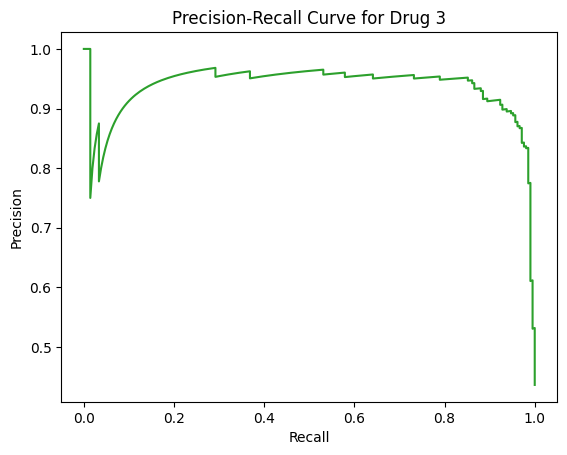

PR-AUC for Drug 3: 0.9351


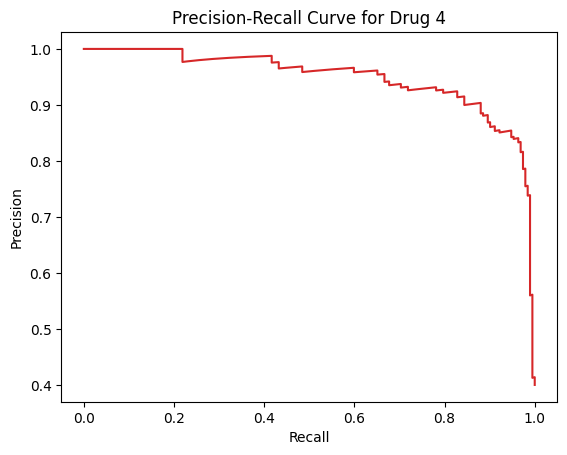

PR-AUC for Drug 4: 0.9486


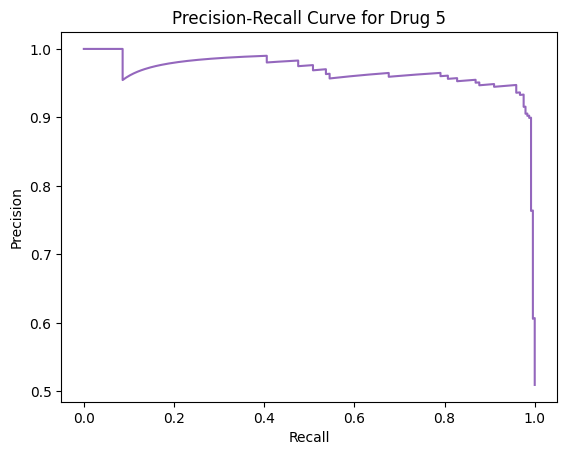

PR-AUC for Drug 5: 0.9677


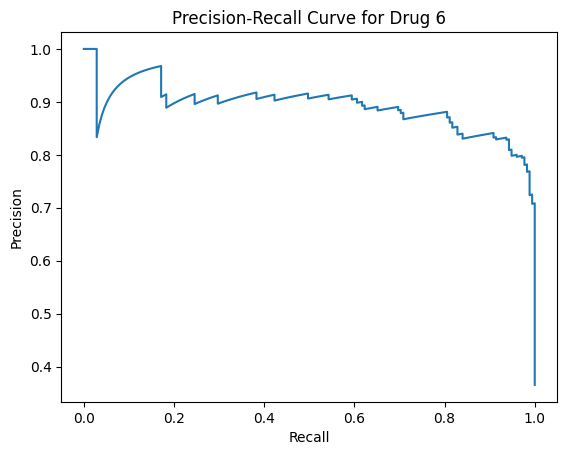

PR-AUC for Drug 6: 0.8920


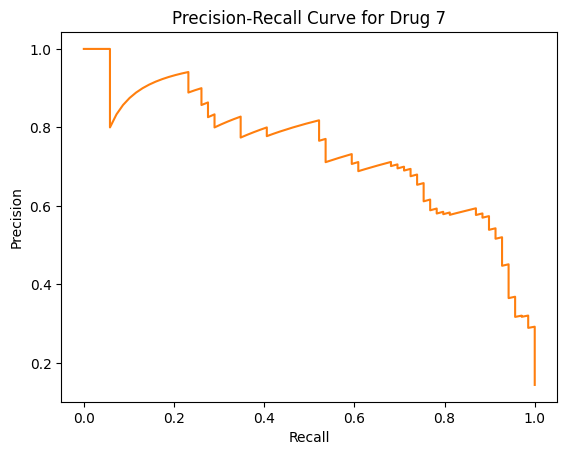

PR-AUC for Drug 7: 0.7394


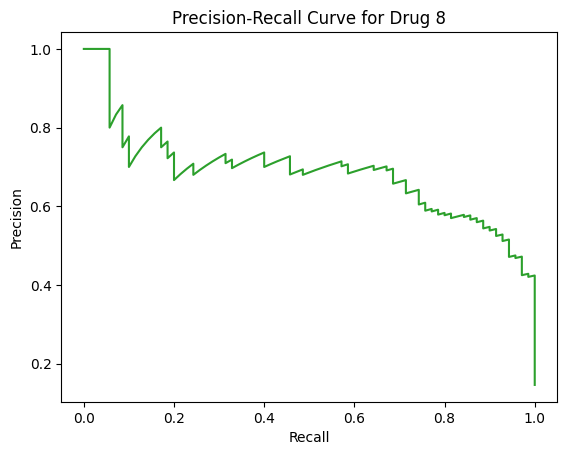

PR-AUC for Drug 8: 0.6844

Epoch 9/20
Training Loss: 0.2311
Validation Loss: 0.2304
Learning Rate: 6.47e-06

Validation Metrics:
----------------------------------------
Precision: 0.8151
Recall: 0.9175
F1 Score: 0.8633
Accuracy: 0.9016
Specificity: 0.8935
Npv: 0.9549

Confusion Matrix Elements:
True Positives: 1190
True Negatives: 2265
False Positives: 270
False Negatives: 107
----------------------------------------


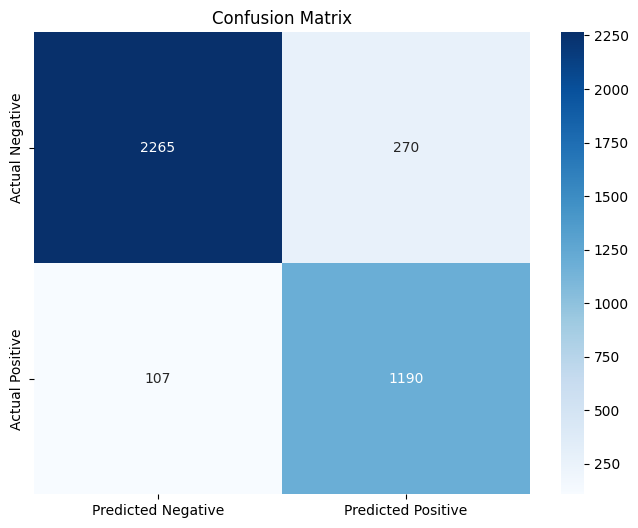

Saved best model!


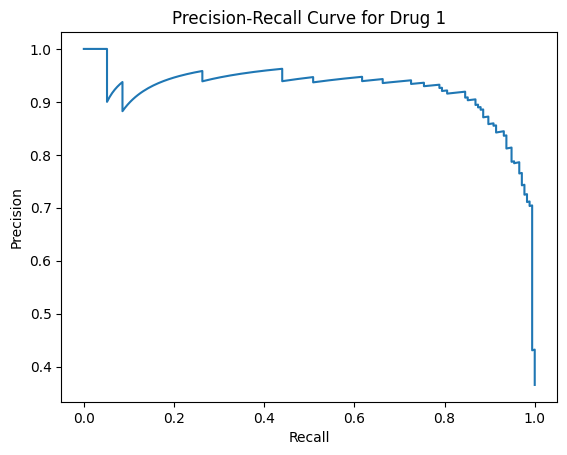

PR-AUC for Drug 1: 0.9231


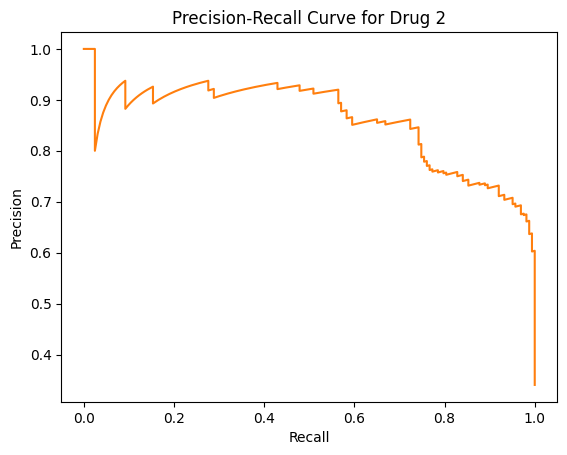

PR-AUC for Drug 2: 0.8595


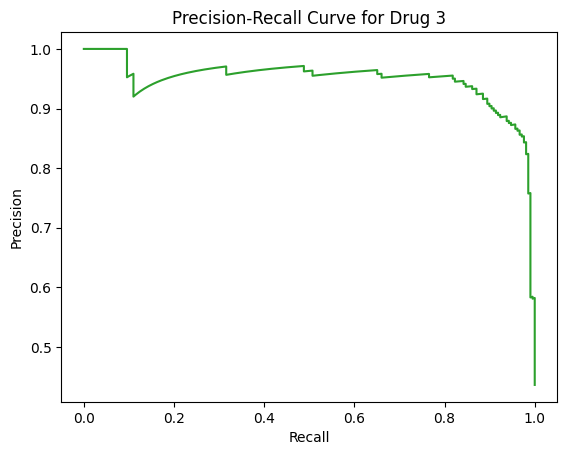

PR-AUC for Drug 3: 0.9484


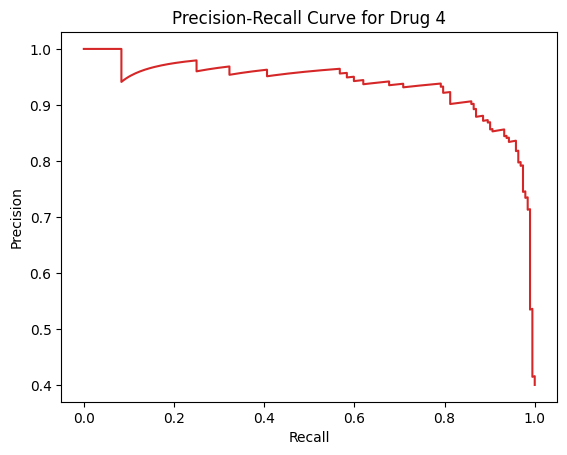

PR-AUC for Drug 4: 0.9358


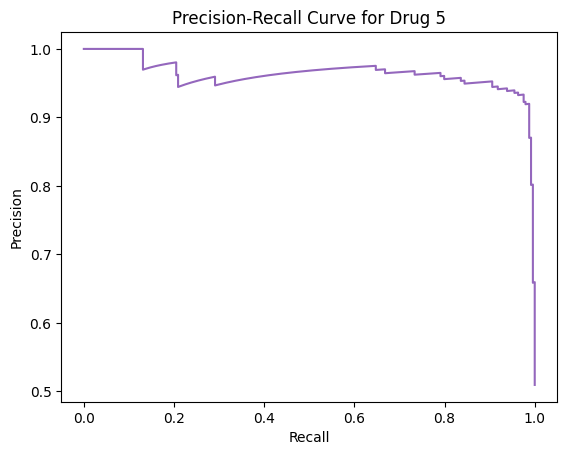

PR-AUC for Drug 5: 0.9634


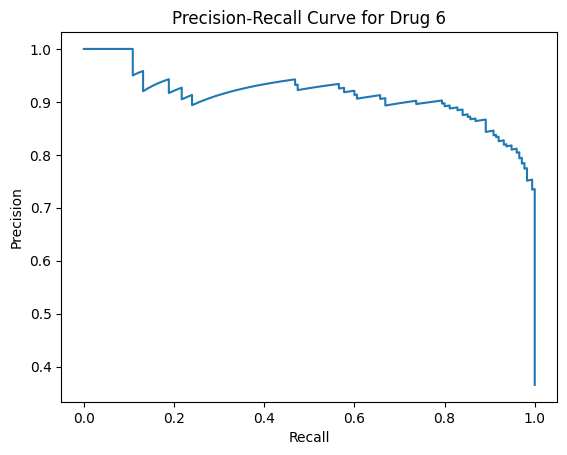

PR-AUC for Drug 6: 0.9118


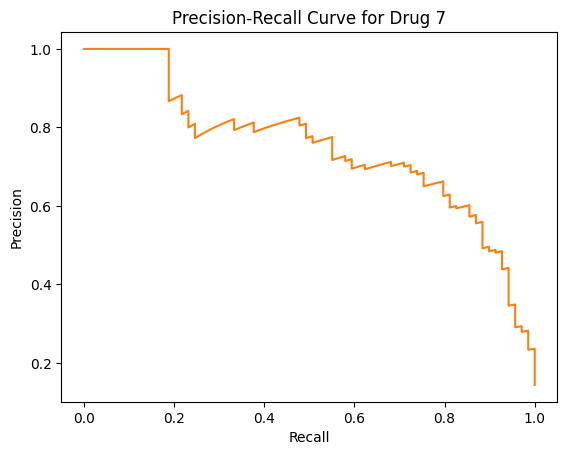

PR-AUC for Drug 7: 0.7474


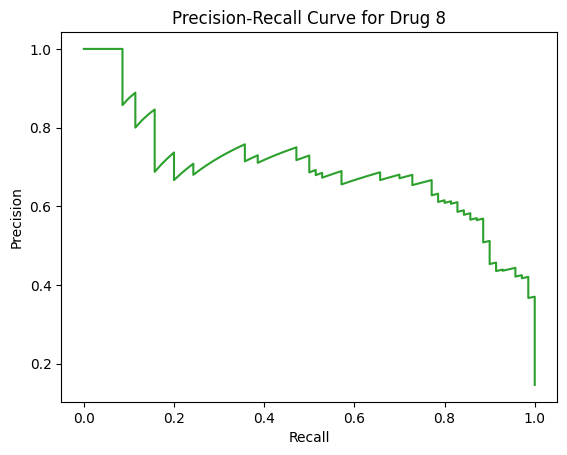

PR-AUC for Drug 8: 0.6935

Epoch 10/20
Training Loss: 0.2225
Validation Loss: 0.2299
Learning Rate: 5.88e-06

Validation Metrics:
----------------------------------------
Precision: 0.8710
Recall: 0.8435
F1 Score: 0.8570
Accuracy: 0.9047
Specificity: 0.9361
Npv: 0.9212

Confusion Matrix Elements:
True Positives: 1094
True Negatives: 2373
False Positives: 162
False Negatives: 203
----------------------------------------


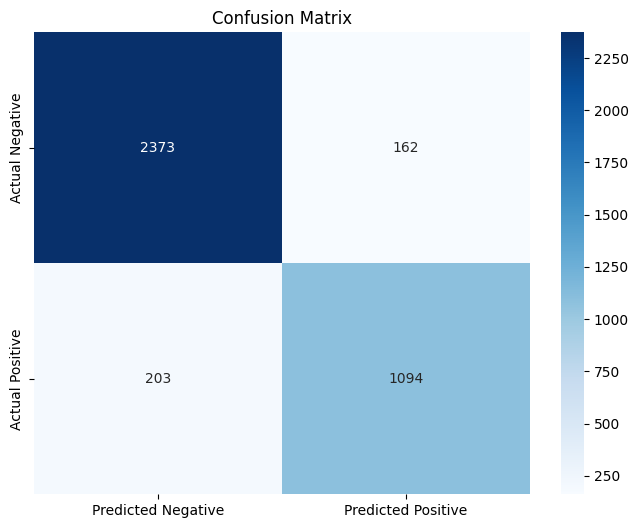

Saved best model!


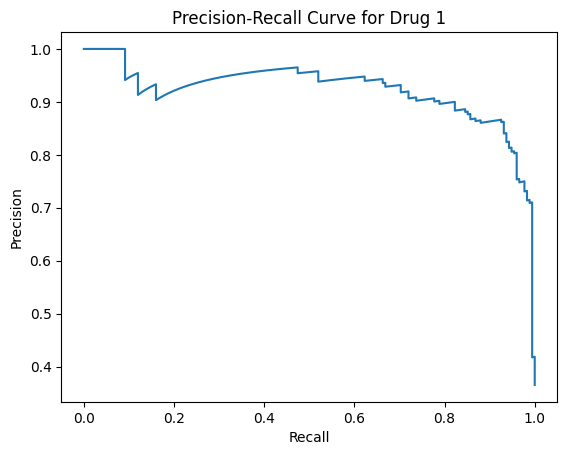

PR-AUC for Drug 1: 0.9219


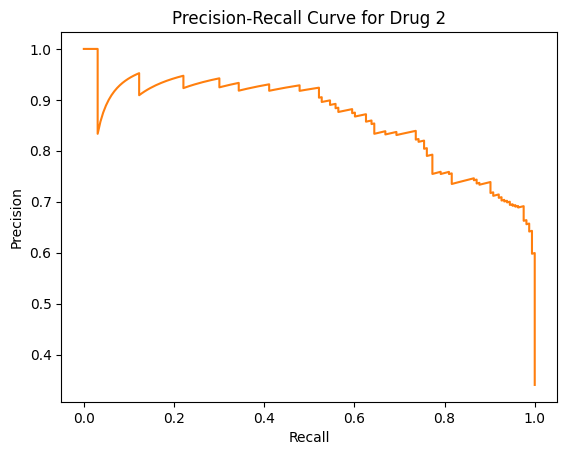

PR-AUC for Drug 2: 0.8628


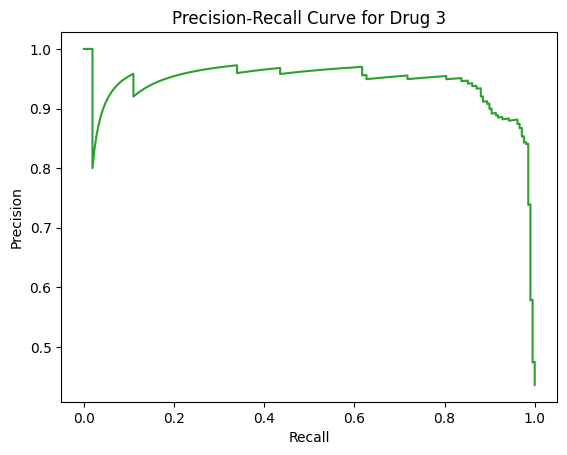

PR-AUC for Drug 3: 0.9412


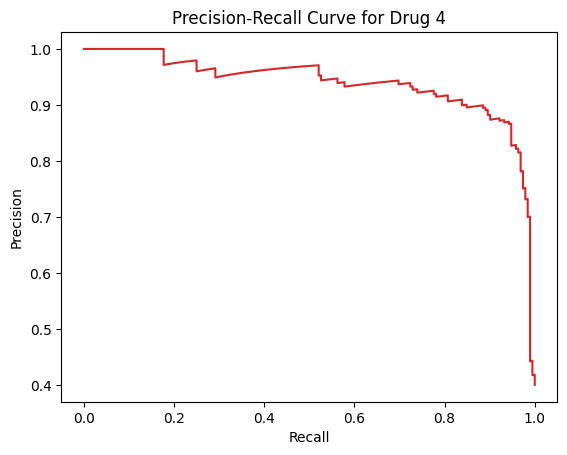

PR-AUC for Drug 4: 0.9390


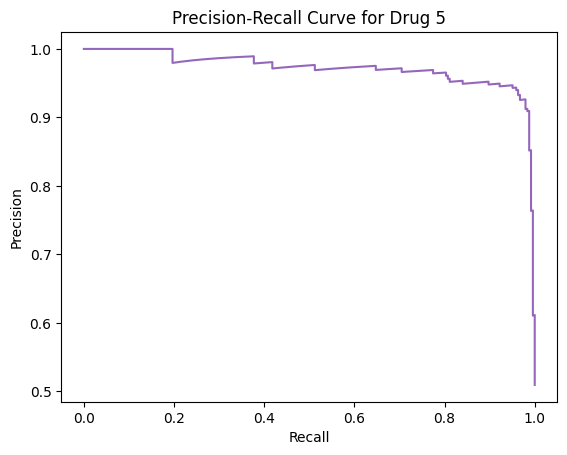

PR-AUC for Drug 5: 0.9723


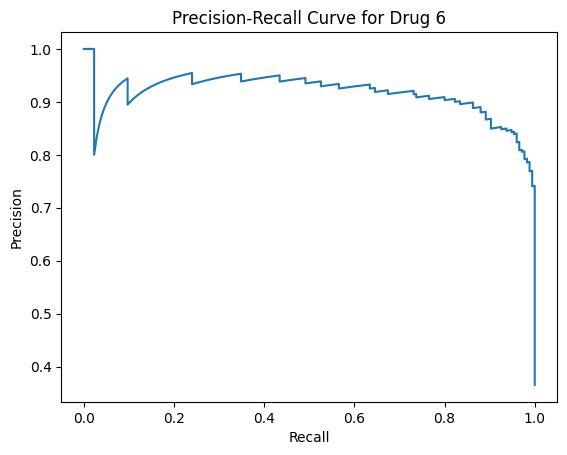

PR-AUC for Drug 6: 0.9170


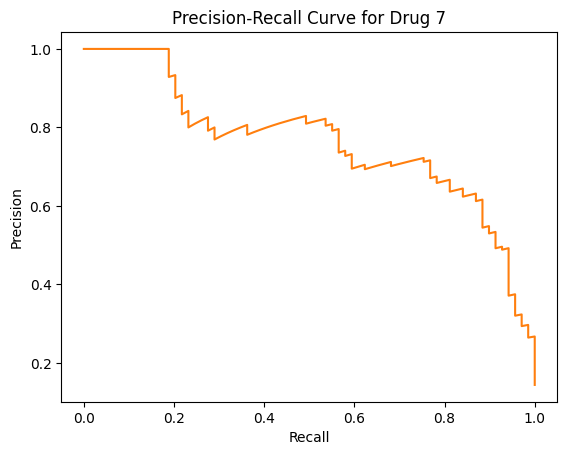

PR-AUC for Drug 7: 0.7618


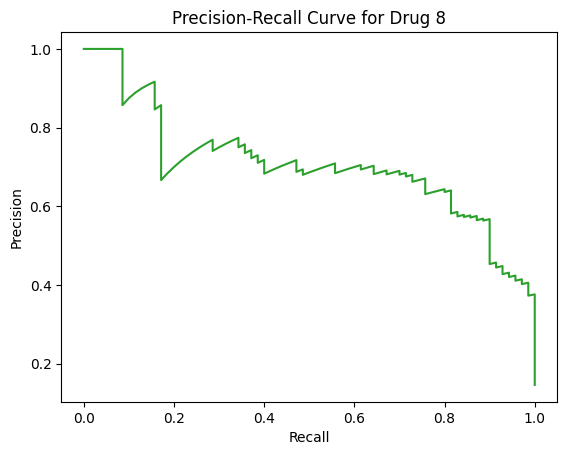

PR-AUC for Drug 8: 0.7041

Epoch 11/20
Training Loss: 0.2133
Validation Loss: 0.2265
Learning Rate: 5.29e-06

Validation Metrics:
----------------------------------------
Precision: 0.8468
Recall: 0.8867
F1 Score: 0.8663
Accuracy: 0.9074
Specificity: 0.9179
Npv: 0.9406

Confusion Matrix Elements:
True Positives: 1150
True Negatives: 2327
False Positives: 208
False Negatives: 147
----------------------------------------


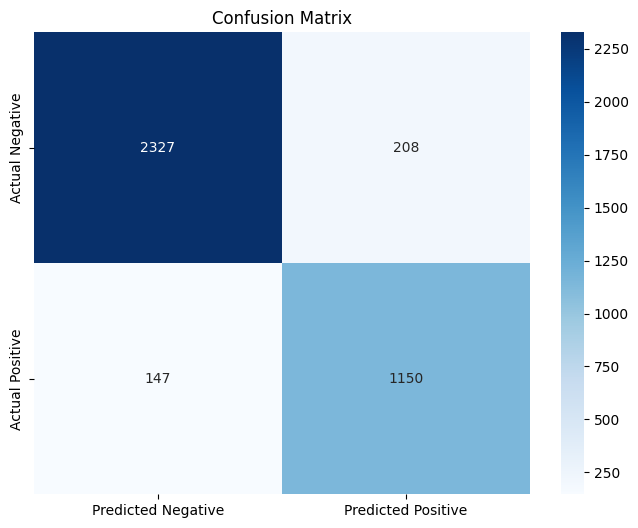

Saved best model!


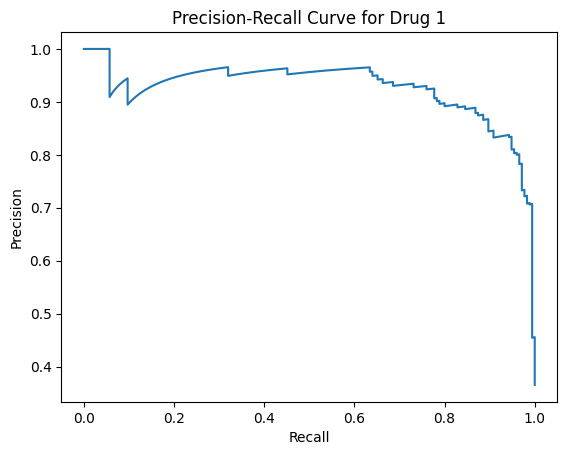

PR-AUC for Drug 1: 0.9260


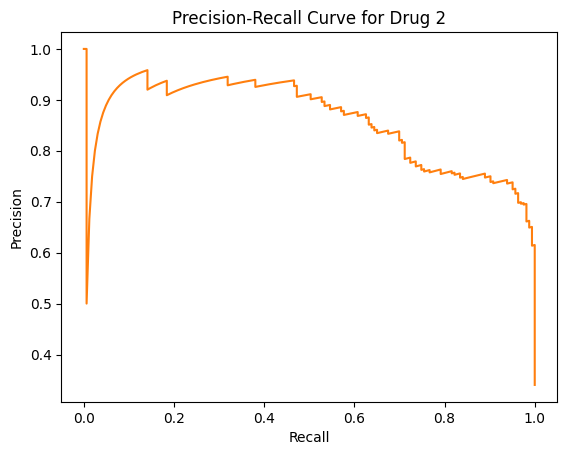

PR-AUC for Drug 2: 0.8567


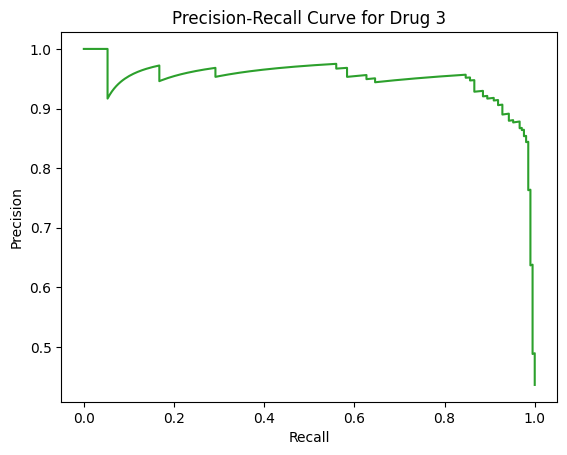

PR-AUC for Drug 3: 0.9486


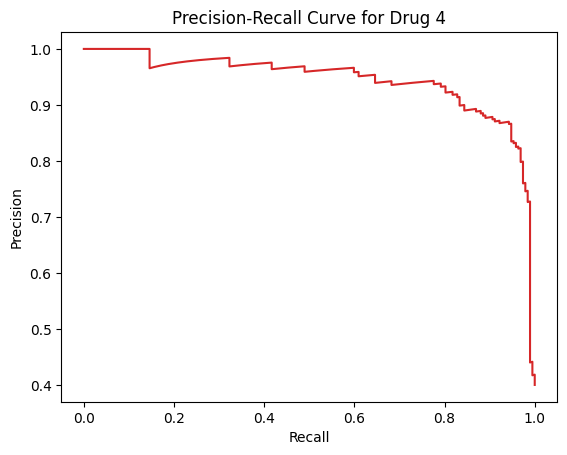

PR-AUC for Drug 4: 0.9446


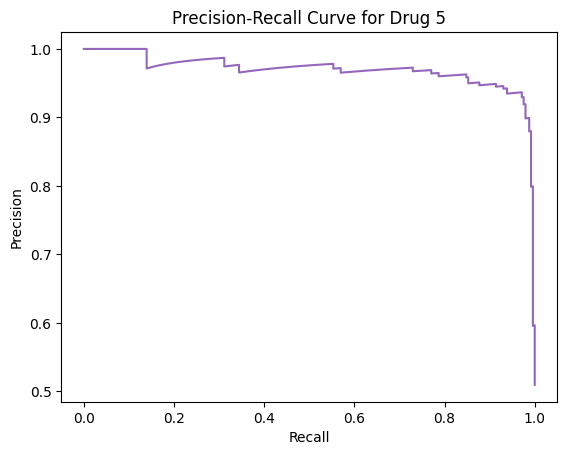

PR-AUC for Drug 5: 0.9695


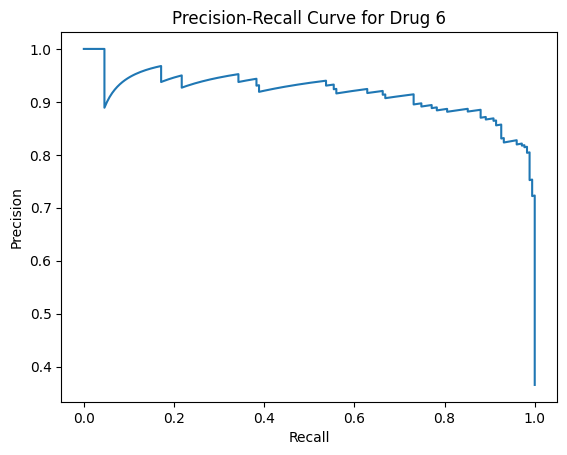

PR-AUC for Drug 6: 0.9168


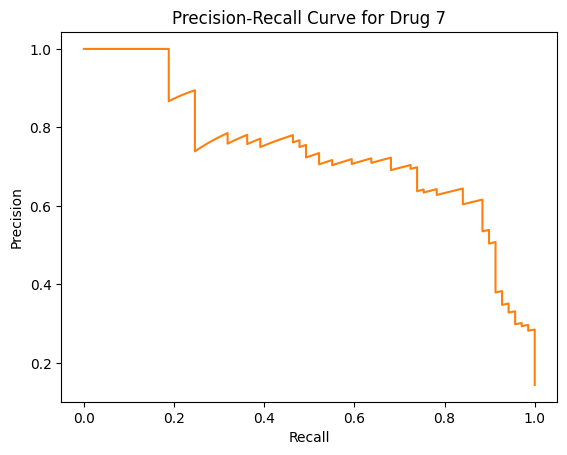

PR-AUC for Drug 7: 0.7378


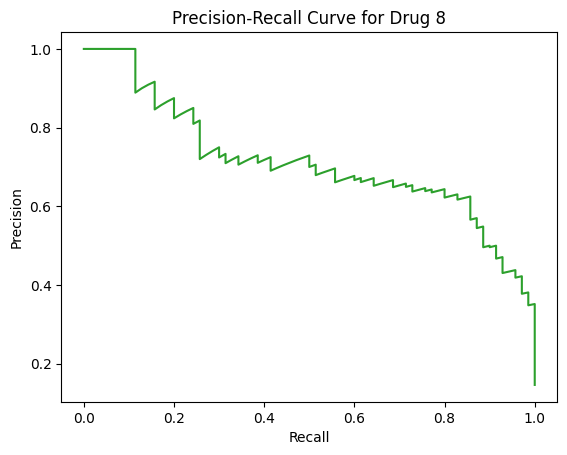

PR-AUC for Drug 8: 0.7123

Epoch 12/20
Training Loss: 0.2031
Validation Loss: 0.2259
Learning Rate: 4.71e-06

Validation Metrics:
----------------------------------------
Precision: 0.8677
Recall: 0.8396
F1 Score: 0.8534
Accuracy: 0.9024
Specificity: 0.9345
Npv: 0.9193

Confusion Matrix Elements:
True Positives: 1089
True Negatives: 2369
False Positives: 166
False Negatives: 208
----------------------------------------


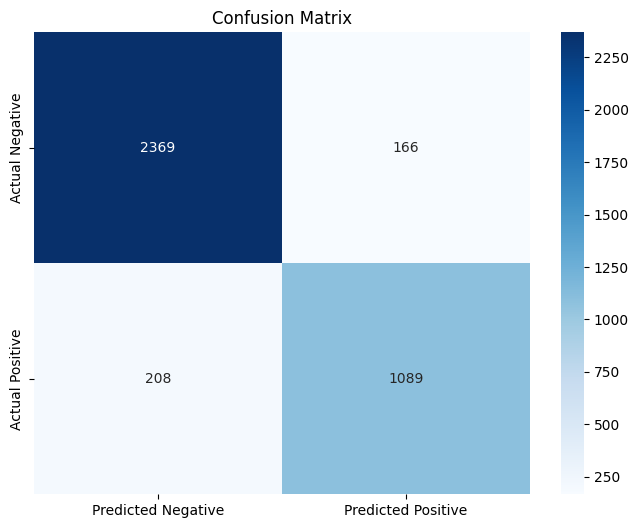

Saved best model!


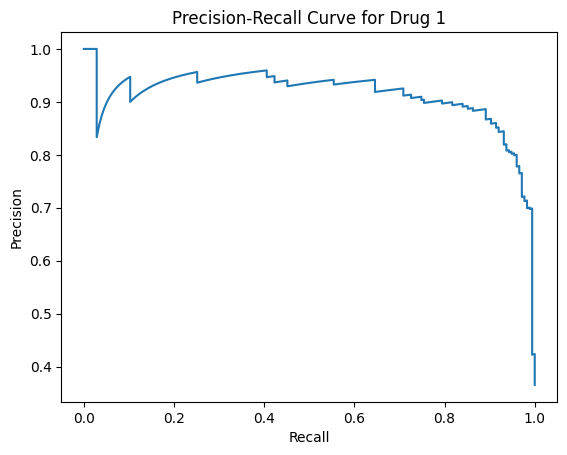

PR-AUC for Drug 1: 0.9137


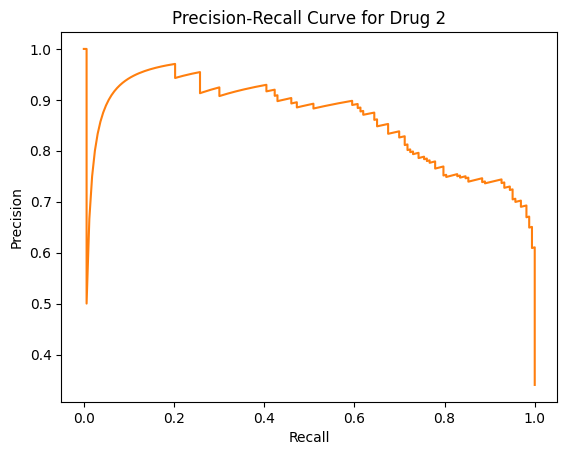

PR-AUC for Drug 2: 0.8576


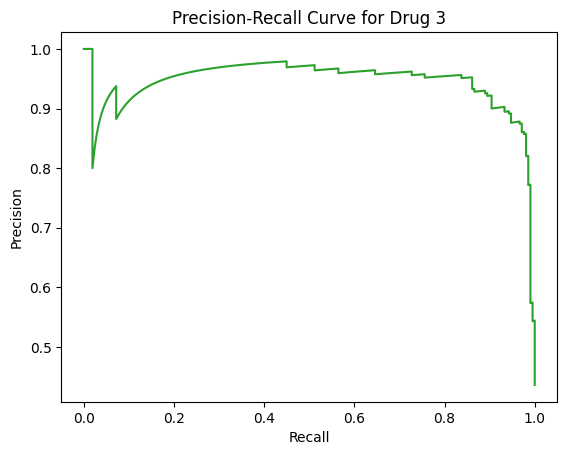

PR-AUC for Drug 3: 0.9438


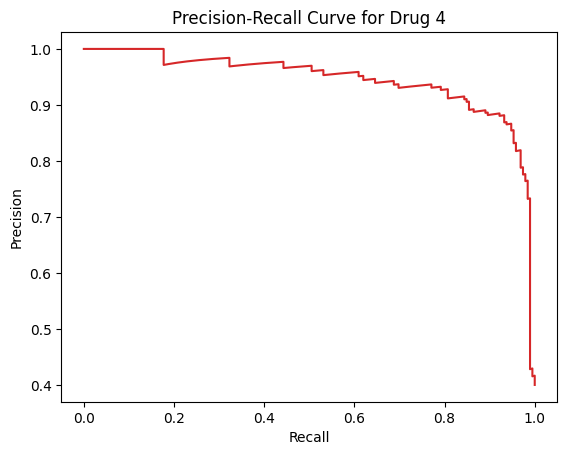

PR-AUC for Drug 4: 0.9454


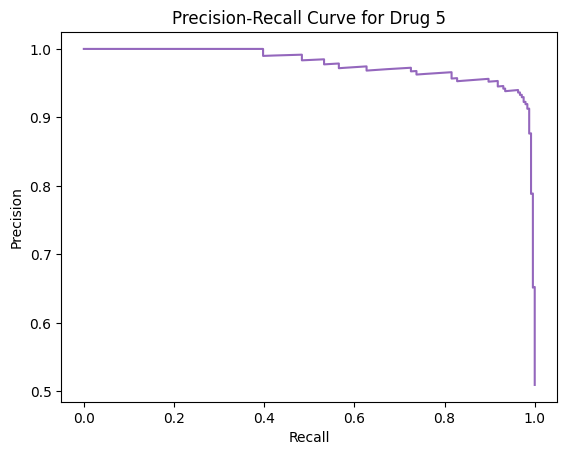

PR-AUC for Drug 5: 0.9780


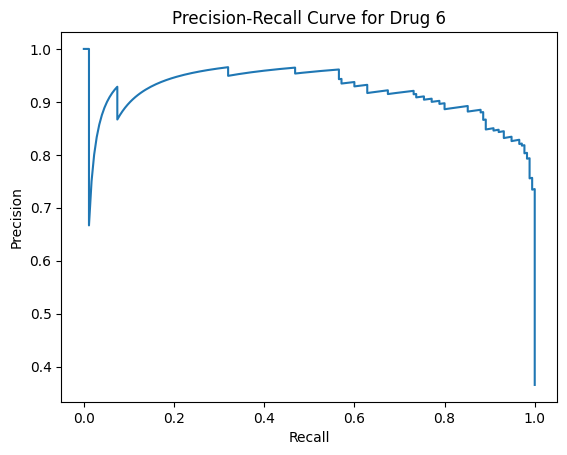

PR-AUC for Drug 6: 0.9165


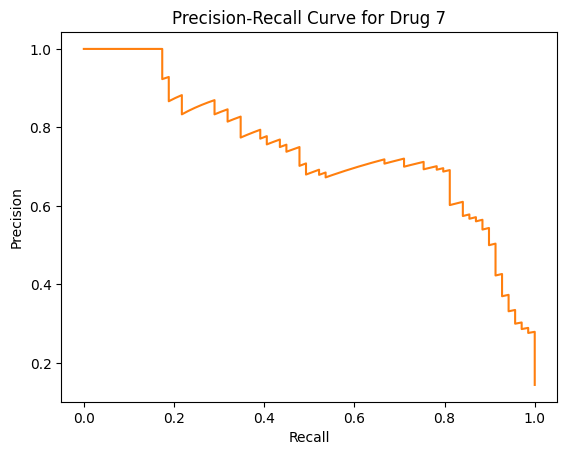

PR-AUC for Drug 7: 0.7419


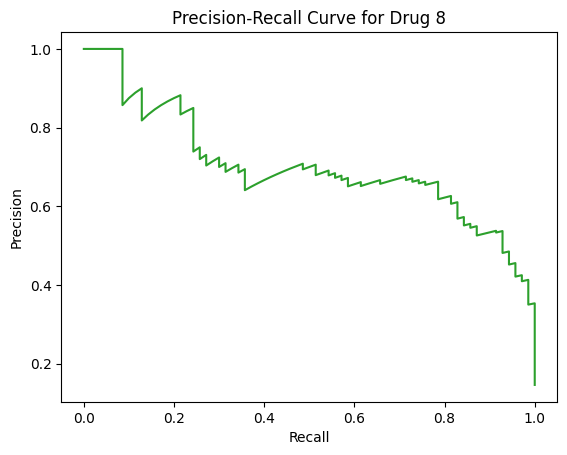

PR-AUC for Drug 8: 0.7011

Epoch 13/20
Training Loss: 0.1964
Validation Loss: 0.2243
Learning Rate: 4.12e-06

Validation Metrics:
----------------------------------------
Precision: 0.8485
Recall: 0.8682
F1 Score: 0.8582
Accuracy: 0.9029
Specificity: 0.9207
Npv: 0.9317

Confusion Matrix Elements:
True Positives: 1126
True Negatives: 2334
False Positives: 201
False Negatives: 171
----------------------------------------


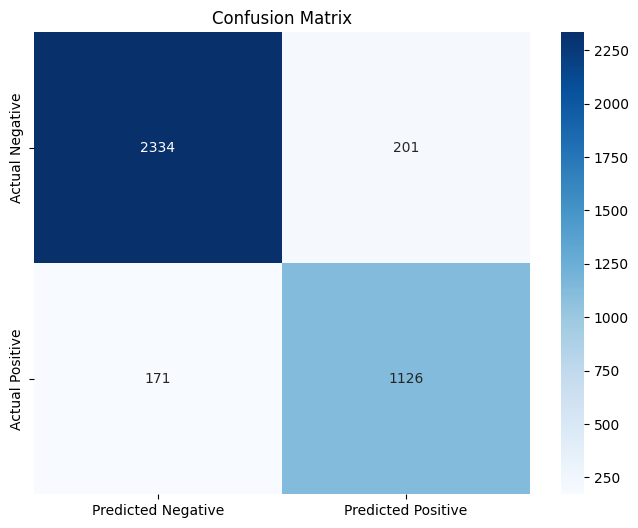

Saved best model!


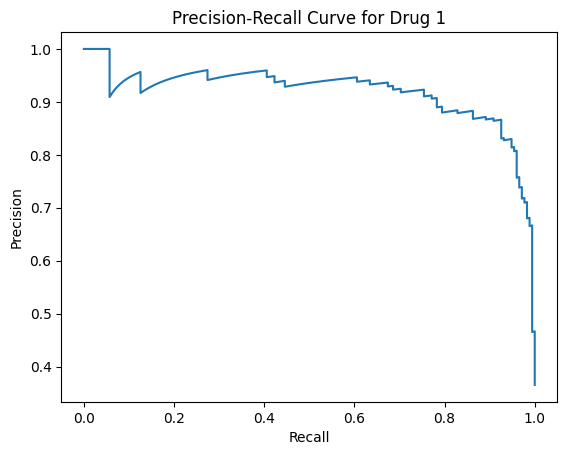

PR-AUC for Drug 1: 0.9190


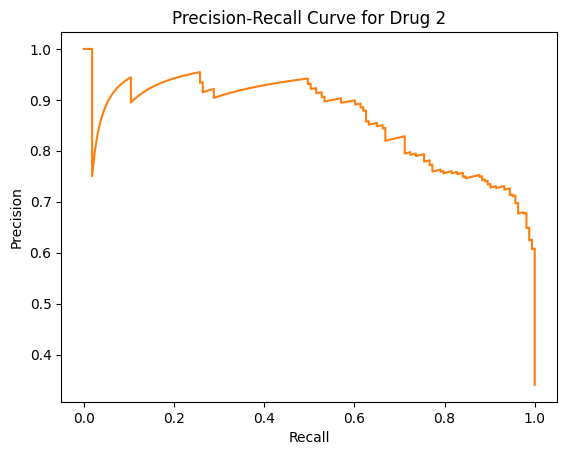

PR-AUC for Drug 2: 0.8613


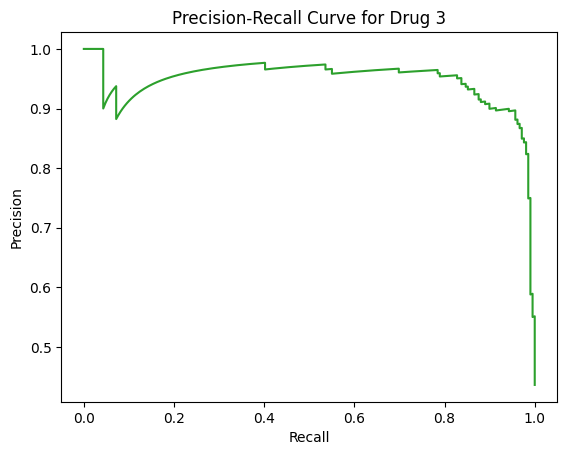

PR-AUC for Drug 3: 0.9467


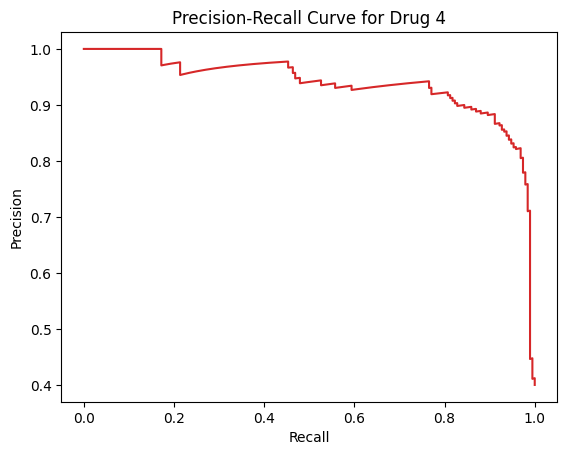

PR-AUC for Drug 4: 0.9379


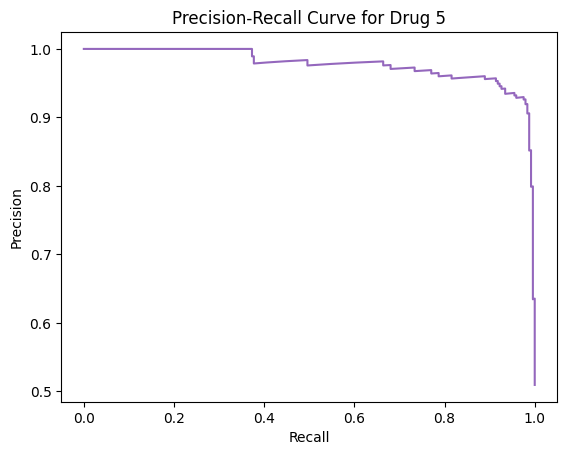

PR-AUC for Drug 5: 0.9775


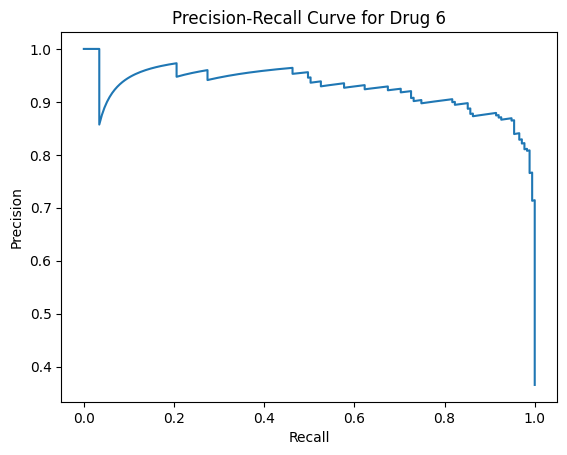

PR-AUC for Drug 6: 0.9265


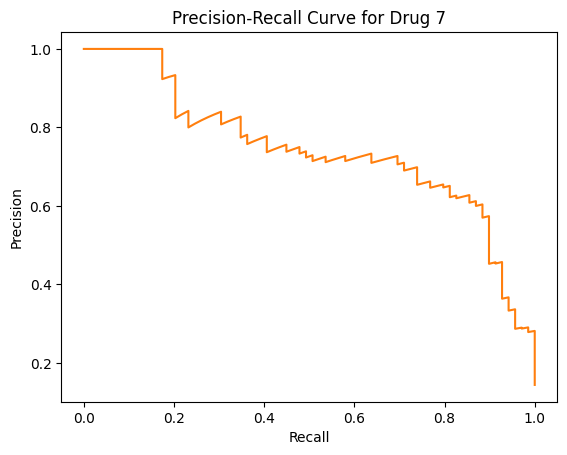

PR-AUC for Drug 7: 0.7422


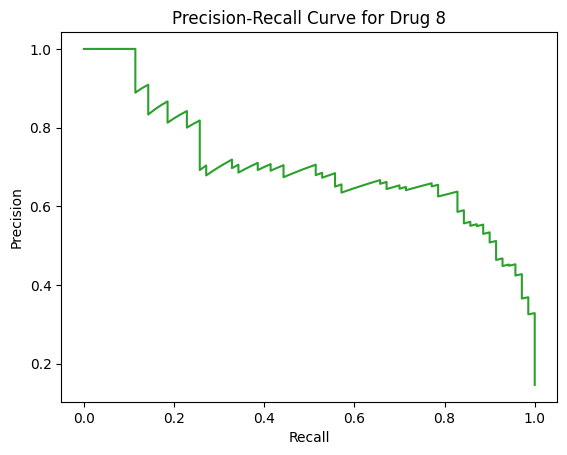

PR-AUC for Drug 8: 0.7018

Epoch 14/20
Training Loss: 0.1899
Validation Loss: 0.2285
Learning Rate: 3.53e-06

Validation Metrics:
----------------------------------------
Precision: 0.8660
Recall: 0.8473
F1 Score: 0.8566
Accuracy: 0.9040
Specificity: 0.9329
Npv: 0.9227

Confusion Matrix Elements:
True Positives: 1099
True Negatives: 2365
False Positives: 170
False Negatives: 198
----------------------------------------


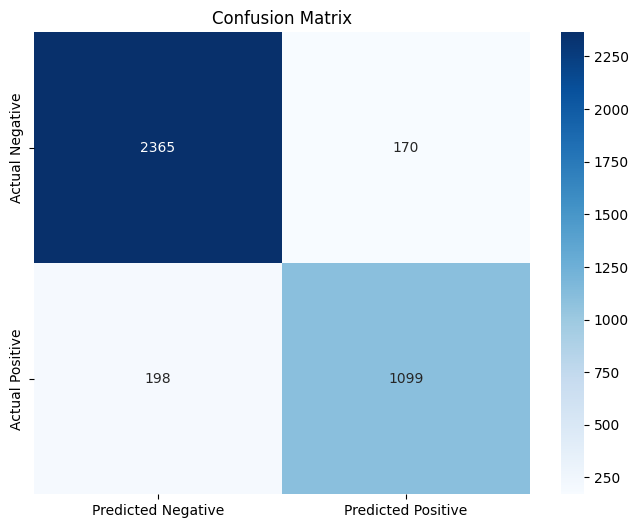

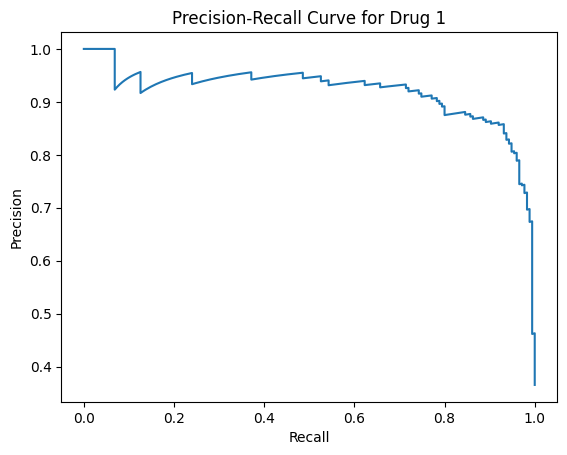

PR-AUC for Drug 1: 0.9202


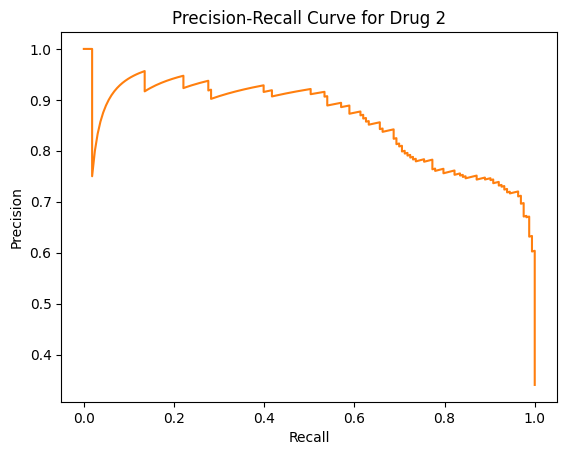

PR-AUC for Drug 2: 0.8593


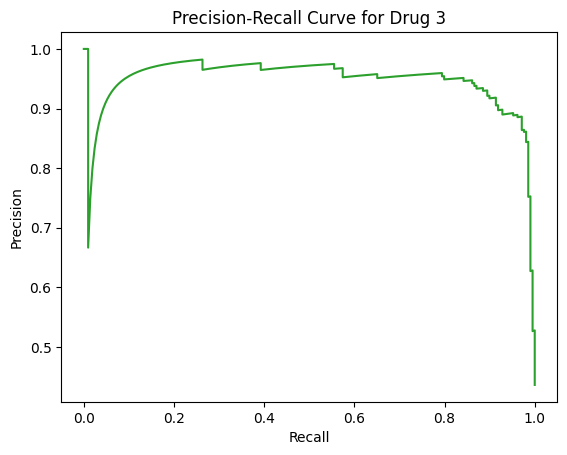

PR-AUC for Drug 3: 0.9464


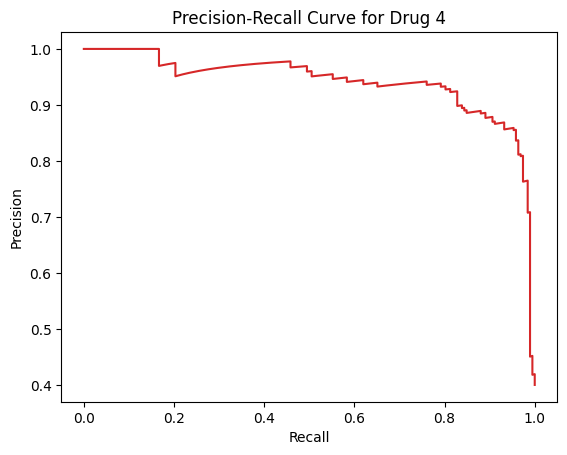

PR-AUC for Drug 4: 0.9414


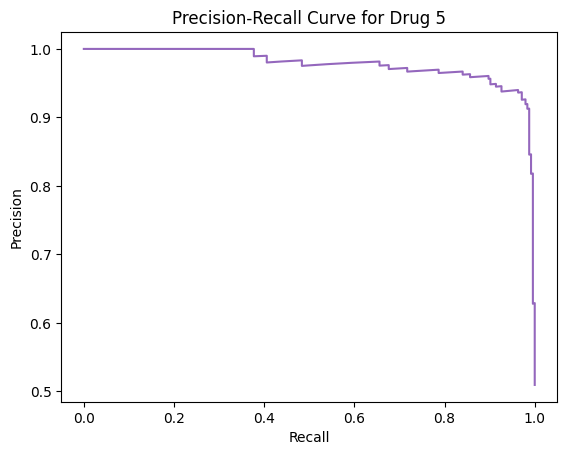

PR-AUC for Drug 5: 0.9782


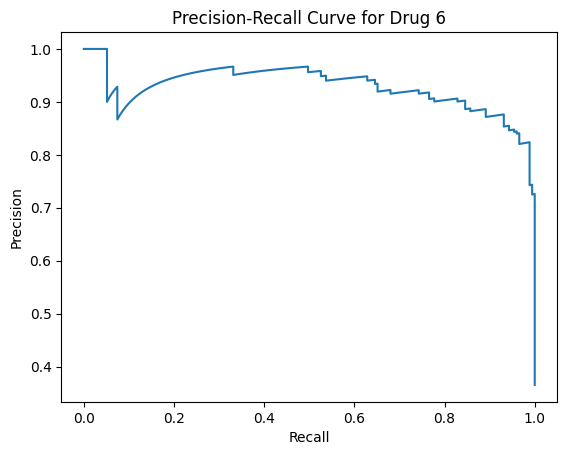

PR-AUC for Drug 6: 0.9277


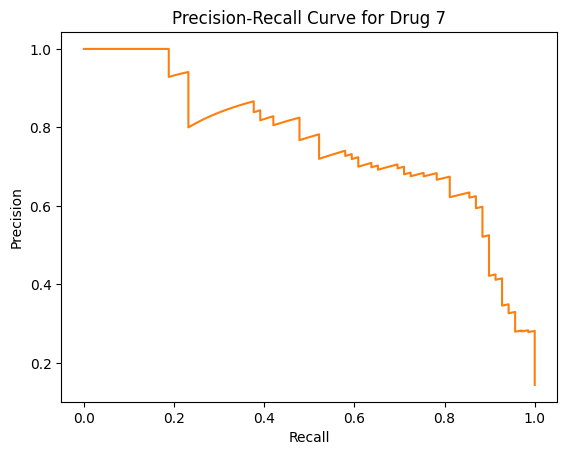

PR-AUC for Drug 7: 0.7575


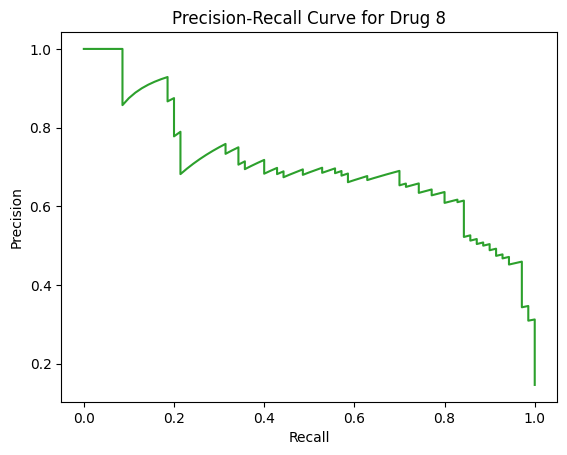

PR-AUC for Drug 8: 0.7010

Epoch 15/20
Training Loss: 0.1868
Validation Loss: 0.2243
Learning Rate: 2.94e-06

Validation Metrics:
----------------------------------------
Precision: 0.8648
Recall: 0.8535
F1 Score: 0.8591
Accuracy: 0.9053
Specificity: 0.9318
Npv: 0.9255

Confusion Matrix Elements:
True Positives: 1107
True Negatives: 2362
False Positives: 173
False Negatives: 190
----------------------------------------


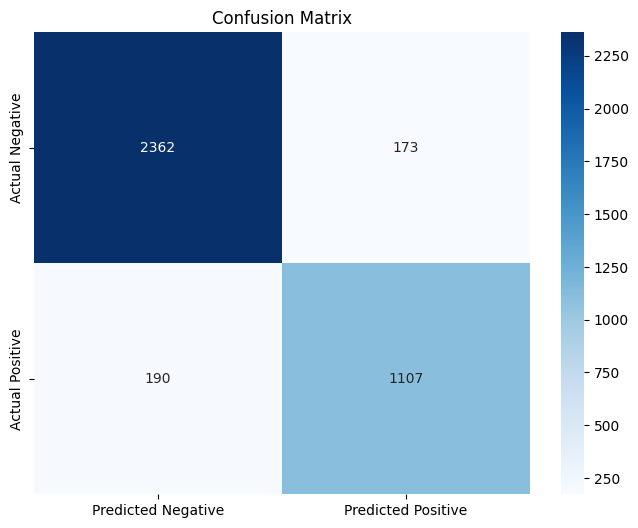

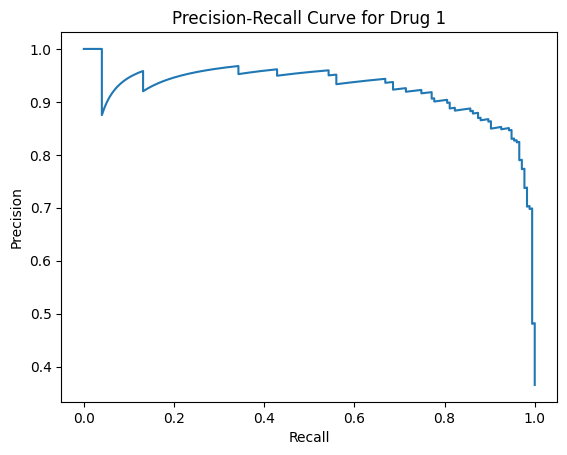

PR-AUC for Drug 1: 0.9240


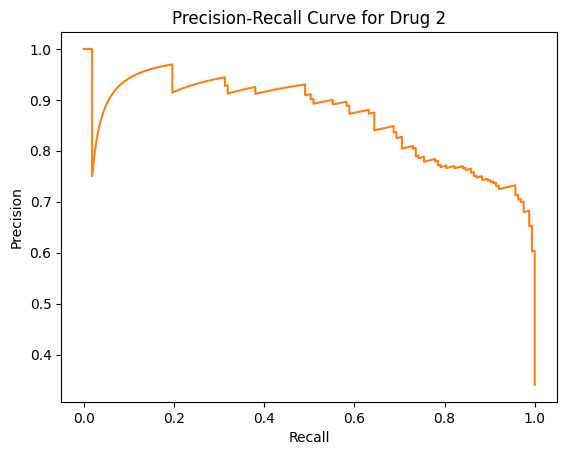

PR-AUC for Drug 2: 0.8650


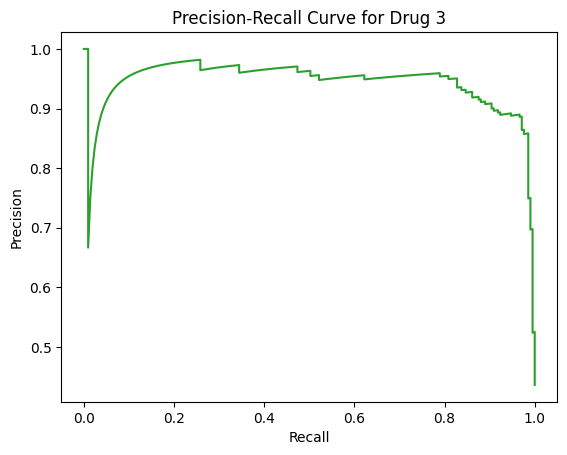

PR-AUC for Drug 3: 0.9425


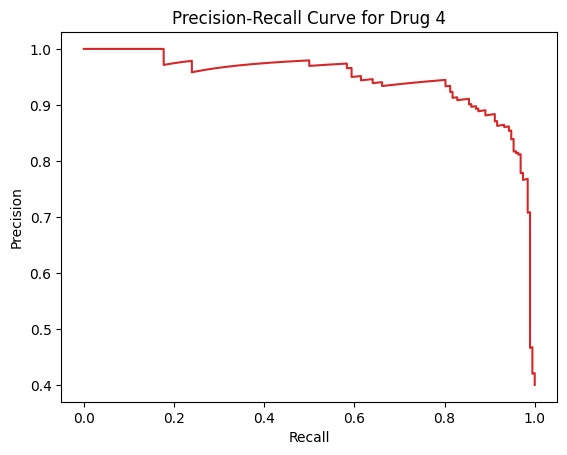

PR-AUC for Drug 4: 0.9459


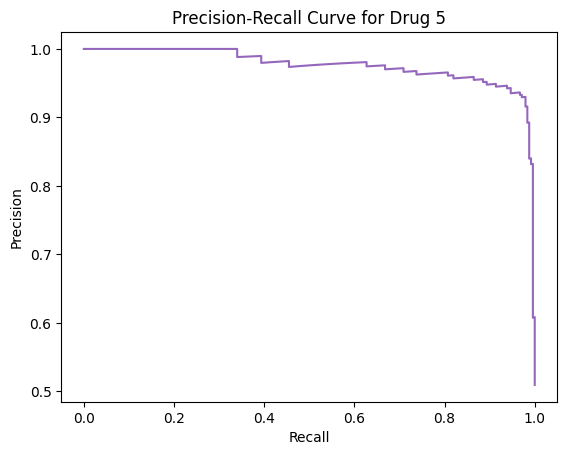

PR-AUC for Drug 5: 0.9763


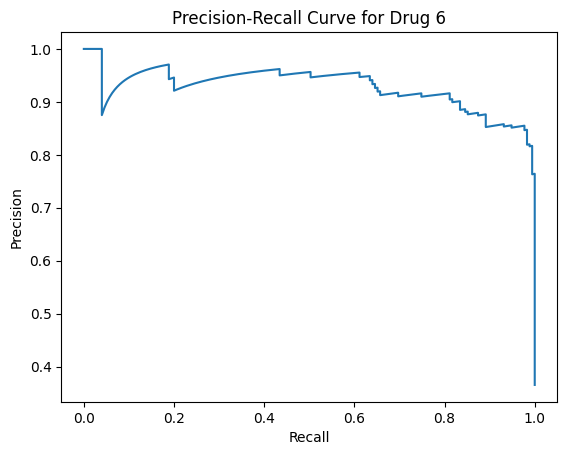

PR-AUC for Drug 6: 0.9280


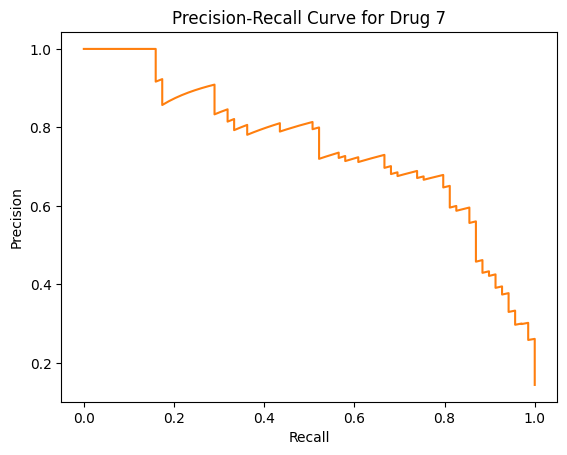

PR-AUC for Drug 7: 0.7467


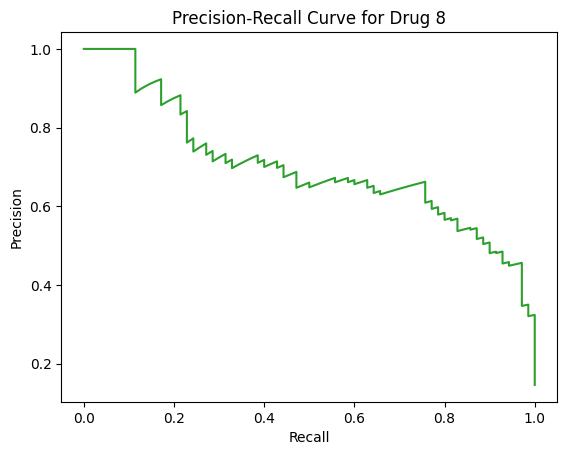

PR-AUC for Drug 8: 0.6993

Epoch 16/20
Training Loss: 0.1795
Validation Loss: 0.2253
Learning Rate: 2.35e-06

Validation Metrics:
----------------------------------------
Precision: 0.8676
Recall: 0.8589
F1 Score: 0.8632
Accuracy: 0.9079
Specificity: 0.9329
Npv: 0.9282

Confusion Matrix Elements:
True Positives: 1114
True Negatives: 2365
False Positives: 170
False Negatives: 183
----------------------------------------


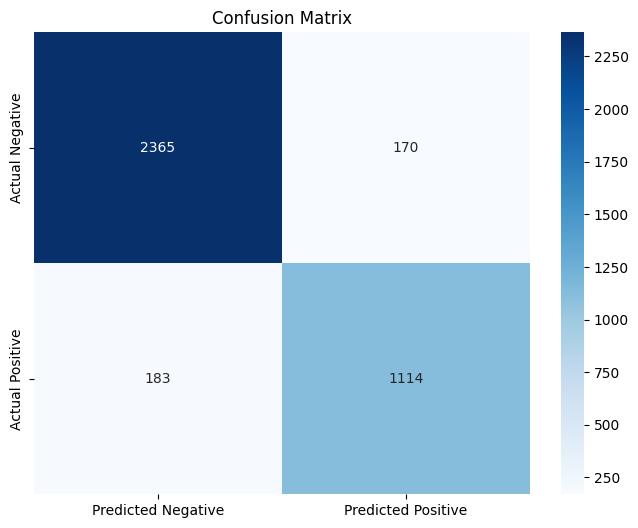

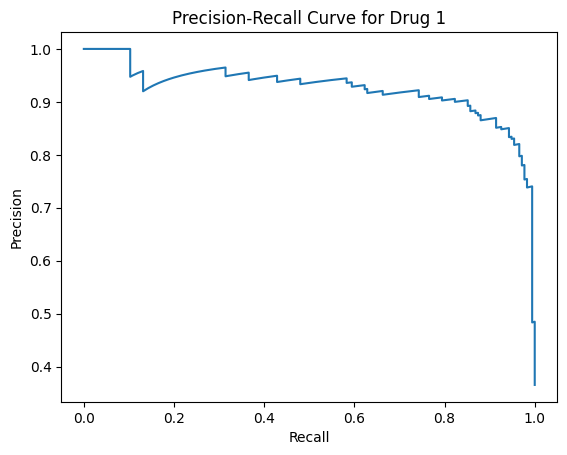

PR-AUC for Drug 1: 0.9254


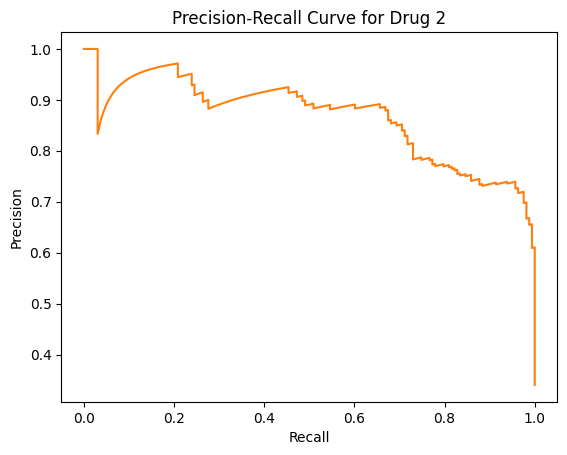

PR-AUC for Drug 2: 0.8658


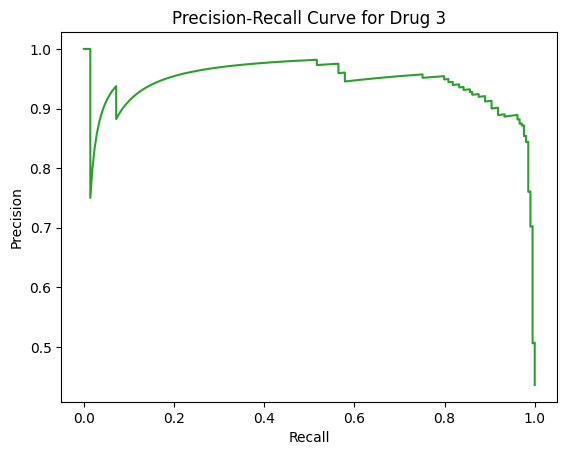

PR-AUC for Drug 3: 0.9414


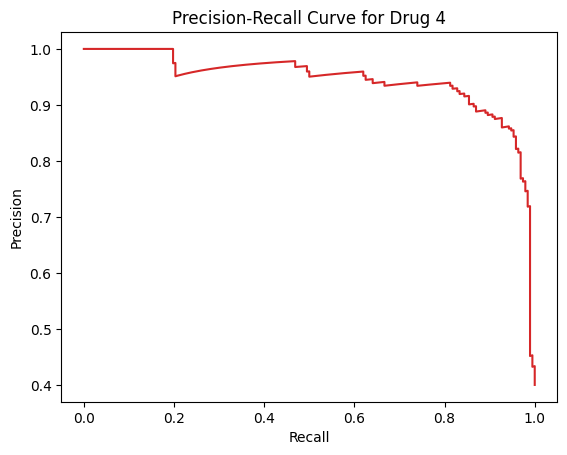

PR-AUC for Drug 4: 0.9445


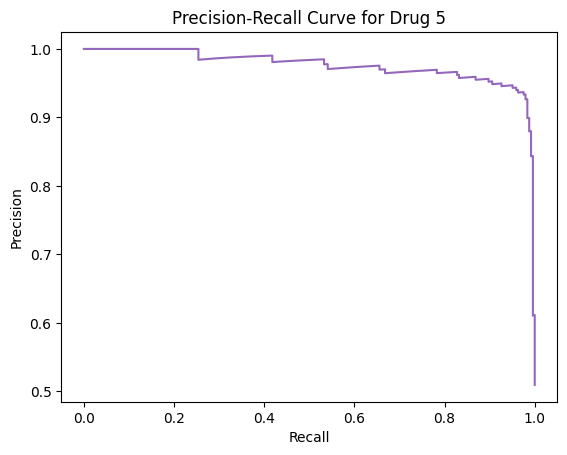

PR-AUC for Drug 5: 0.9762


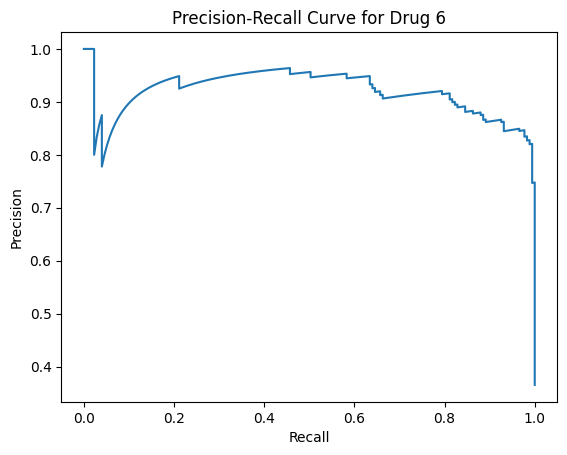

PR-AUC for Drug 6: 0.9182


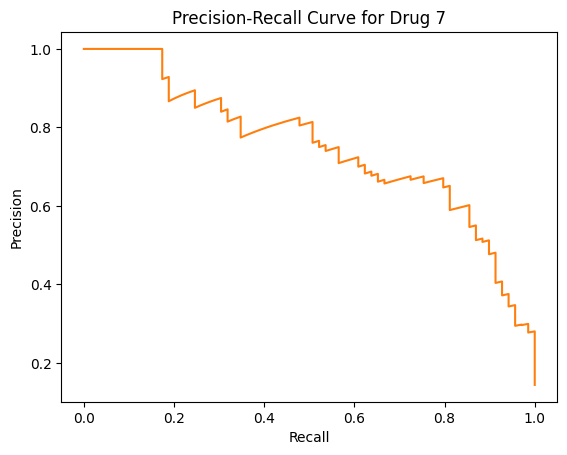

PR-AUC for Drug 7: 0.7479


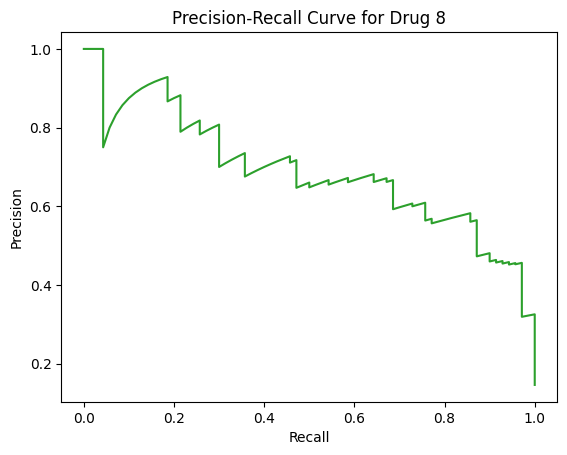

PR-AUC for Drug 8: 0.6885

Epoch 17/20
Training Loss: 0.1754
Validation Loss: 0.2226
Learning Rate: 1.76e-06

Validation Metrics:
----------------------------------------
Precision: 0.8592
Recall: 0.8751
F1 Score: 0.8671
Accuracy: 0.9092
Specificity: 0.9266
Npv: 0.9355

Confusion Matrix Elements:
True Positives: 1135
True Negatives: 2349
False Positives: 186
False Negatives: 162
----------------------------------------


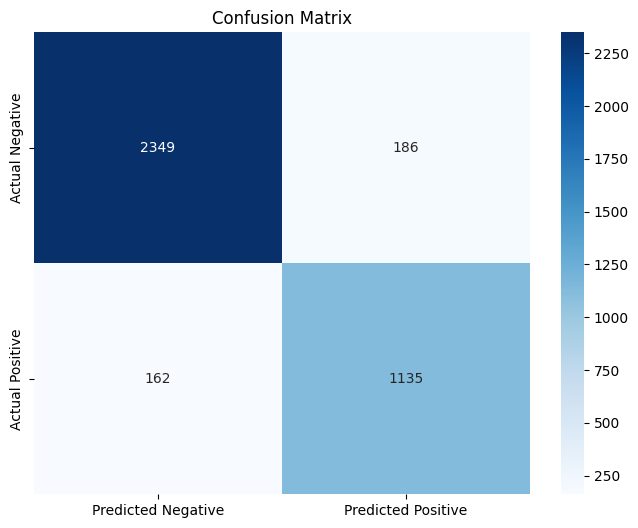

Saved best model!


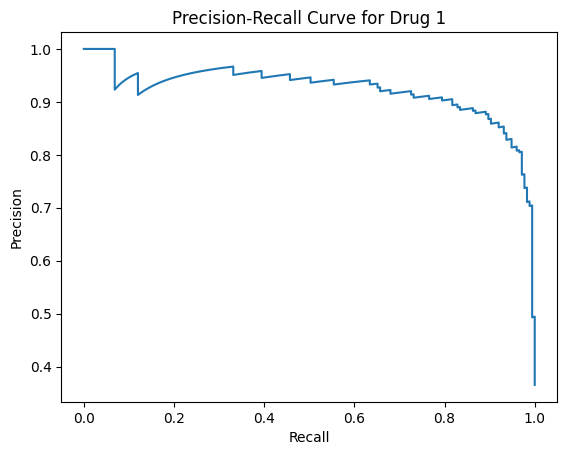

PR-AUC for Drug 1: 0.9234


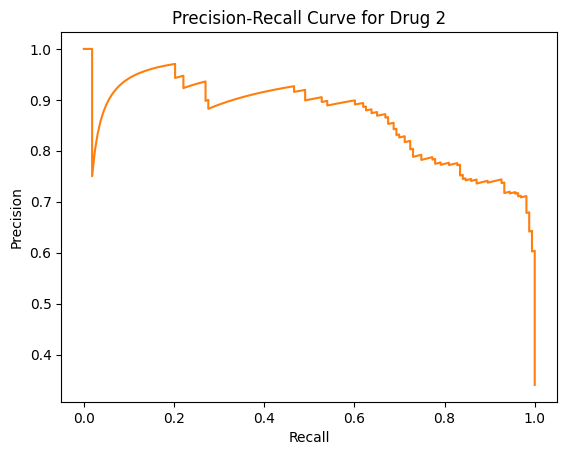

PR-AUC for Drug 2: 0.8638


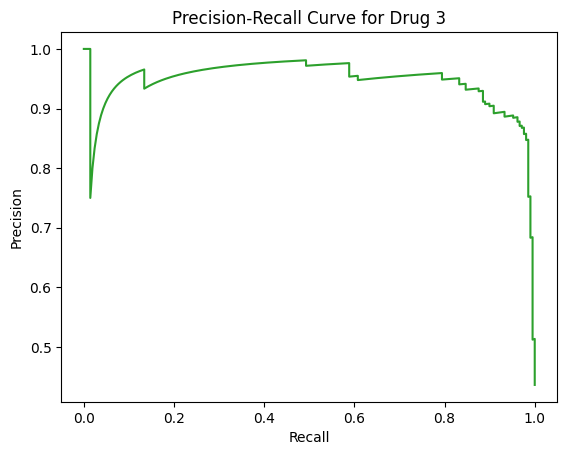

PR-AUC for Drug 3: 0.9449


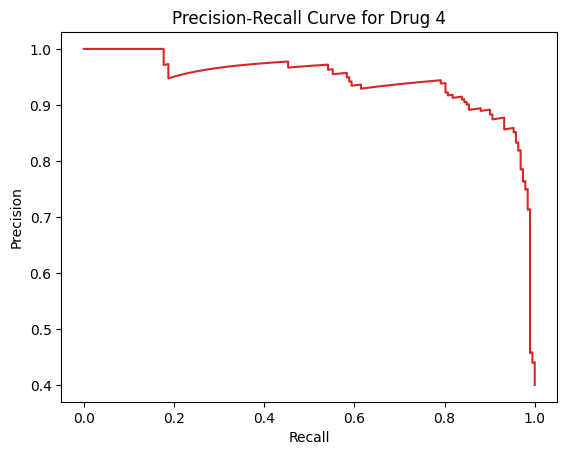

PR-AUC for Drug 4: 0.9428


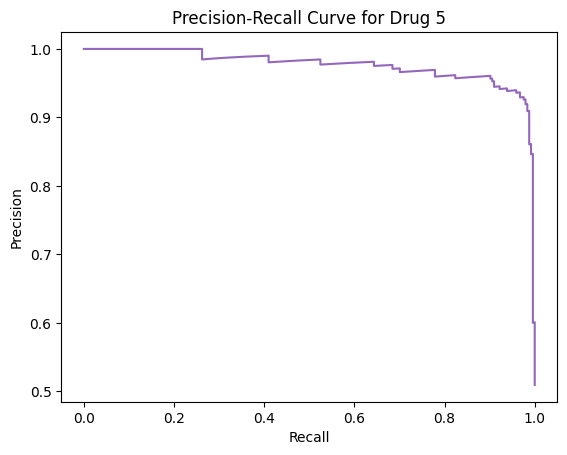

PR-AUC for Drug 5: 0.9766


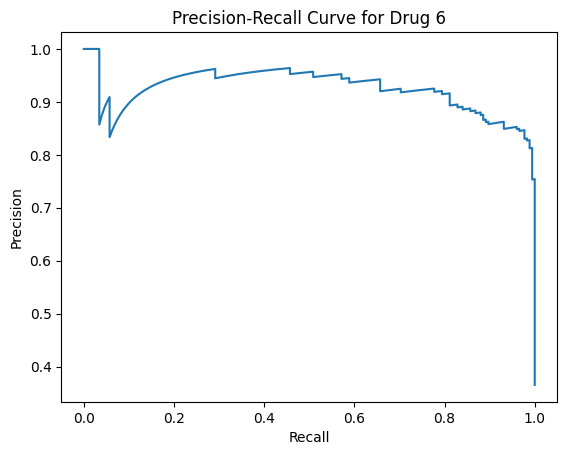

PR-AUC for Drug 6: 0.9242


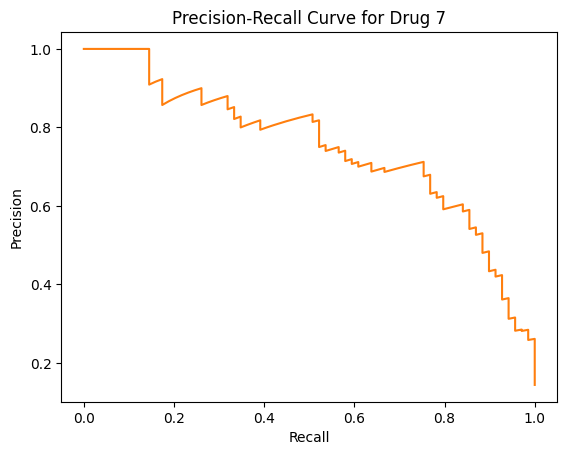

PR-AUC for Drug 7: 0.7488


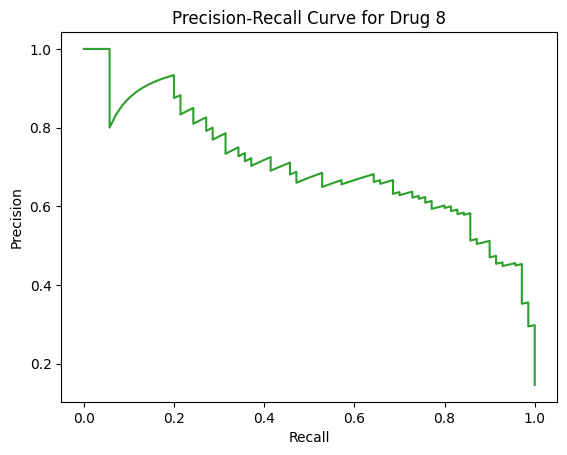

PR-AUC for Drug 8: 0.7011

Epoch 18/20
Training Loss: 0.1732
Validation Loss: 0.2248
Learning Rate: 1.18e-06

Validation Metrics:
----------------------------------------
Precision: 0.8690
Recall: 0.8489
F1 Score: 0.8588
Accuracy: 0.9055
Specificity: 0.9345
Npv: 0.9236

Confusion Matrix Elements:
True Positives: 1101
True Negatives: 2369
False Positives: 166
False Negatives: 196
----------------------------------------


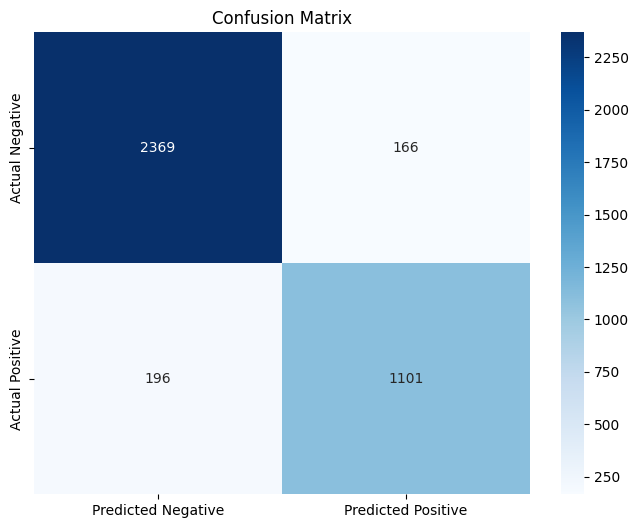

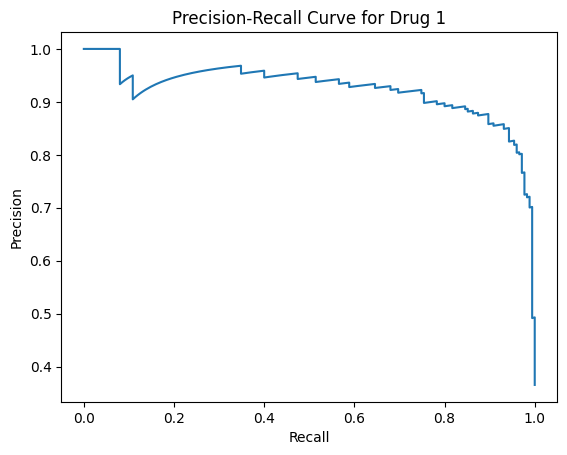

PR-AUC for Drug 1: 0.9239


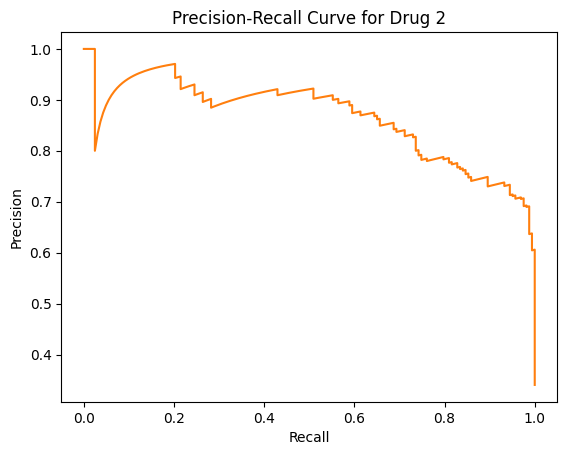

PR-AUC for Drug 2: 0.8650


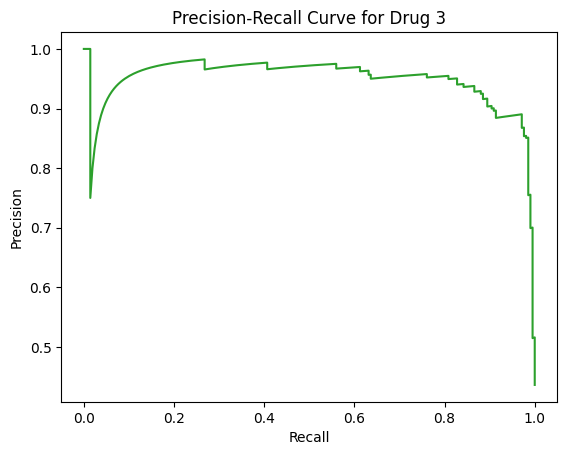

PR-AUC for Drug 3: 0.9476


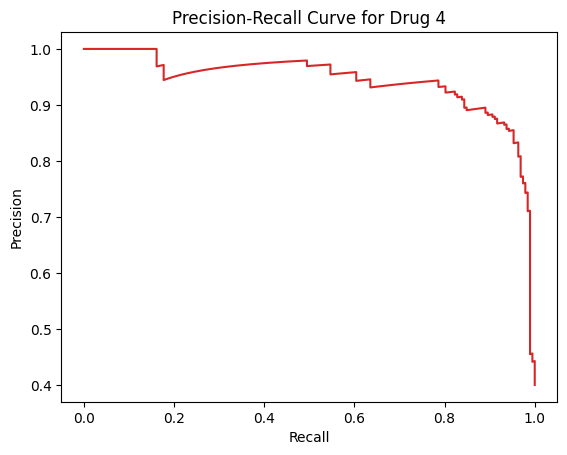

PR-AUC for Drug 4: 0.9428


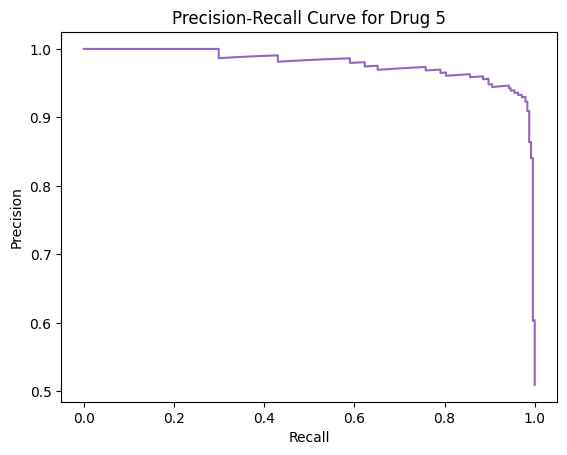

PR-AUC for Drug 5: 0.9781


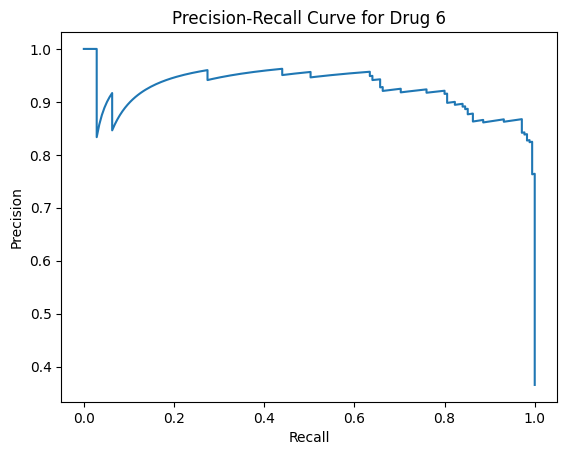

PR-AUC for Drug 6: 0.9246


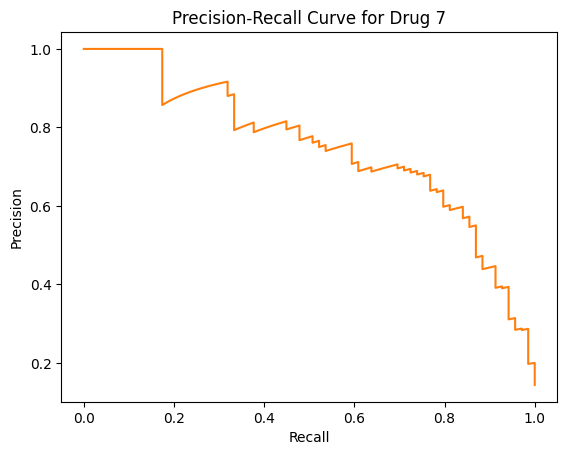

PR-AUC for Drug 7: 0.7481


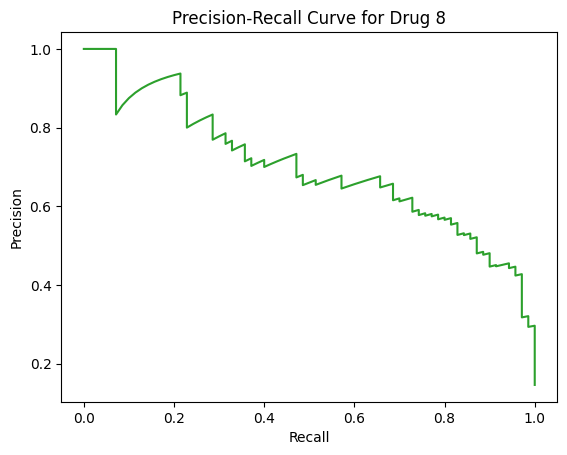

PR-AUC for Drug 8: 0.6985

Epoch 19/20
Training Loss: 0.1700
Validation Loss: 0.2274
Learning Rate: 5.88e-07

Validation Metrics:
----------------------------------------
Precision: 0.8766
Recall: 0.8435
F1 Score: 0.8597
Accuracy: 0.9068
Specificity: 0.9393
Npv: 0.9214

Confusion Matrix Elements:
True Positives: 1094
True Negatives: 2381
False Positives: 154
False Negatives: 203
----------------------------------------


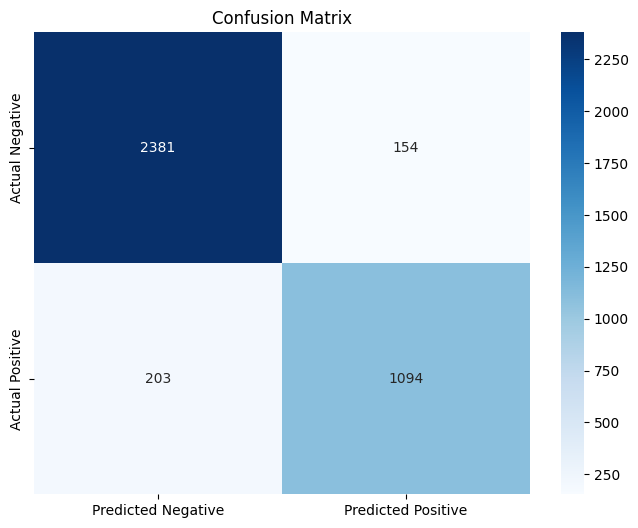

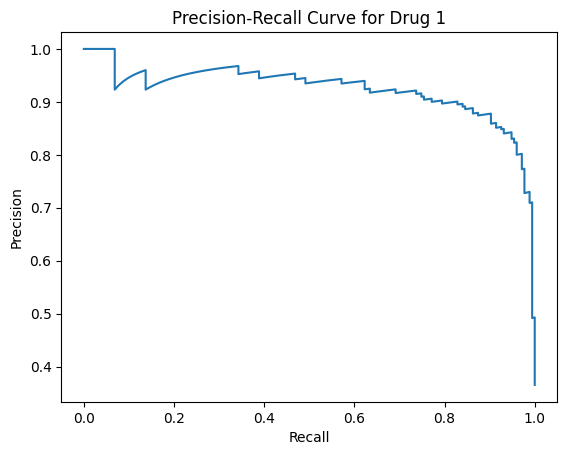

PR-AUC for Drug 1: 0.9241


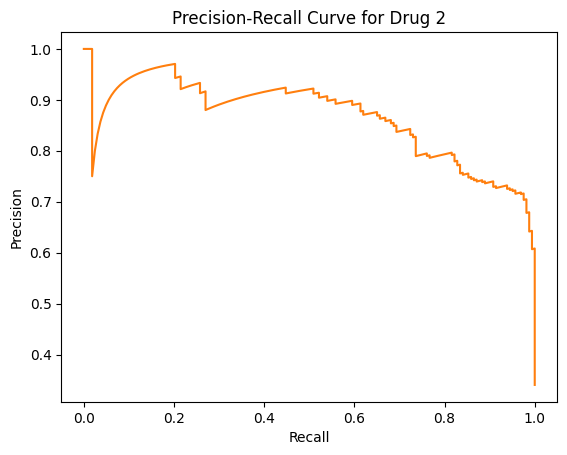

PR-AUC for Drug 2: 0.8655


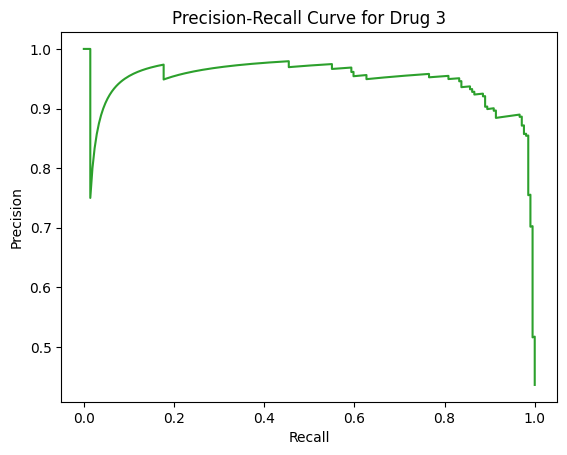

PR-AUC for Drug 3: 0.9456


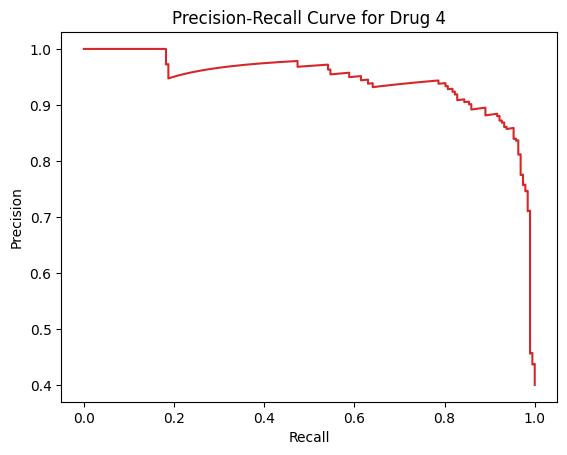

PR-AUC for Drug 4: 0.9439


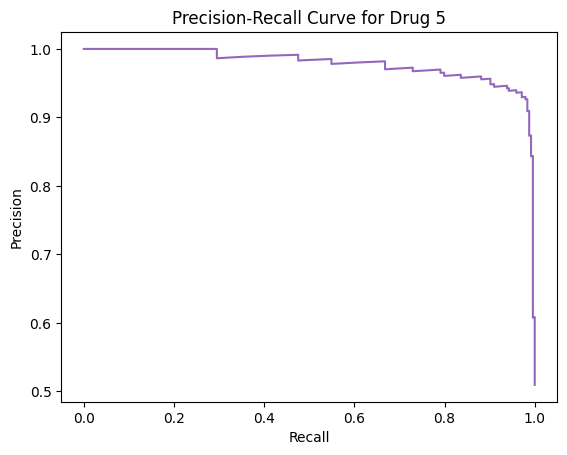

PR-AUC for Drug 5: 0.9784


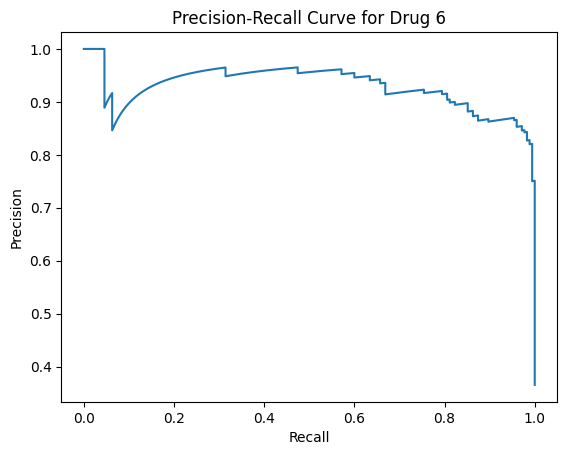

PR-AUC for Drug 6: 0.9284


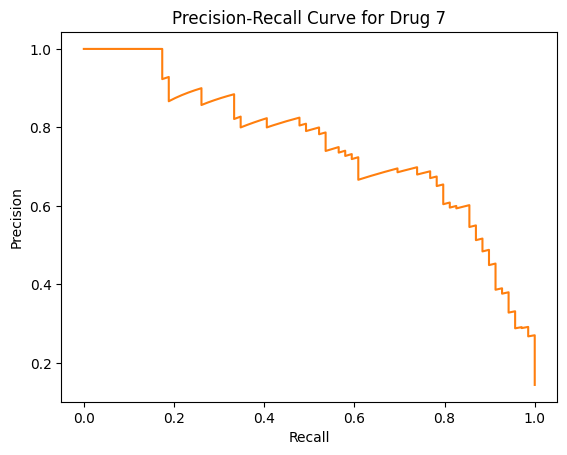

PR-AUC for Drug 7: 0.7524


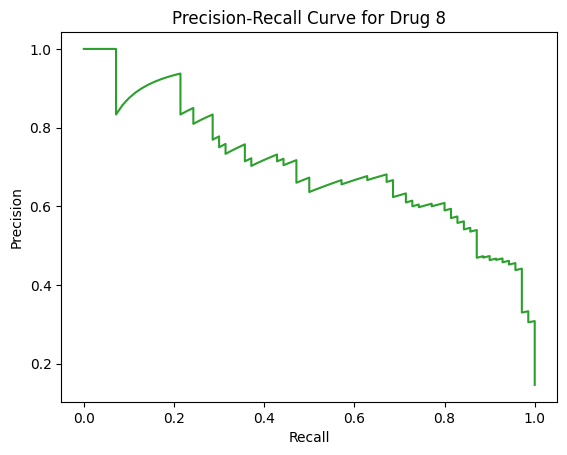

PR-AUC for Drug 8: 0.7023

Epoch 20/20
Training Loss: 0.1689
Validation Loss: 0.2227
Learning Rate: 0.00e+00

Validation Metrics:
----------------------------------------
Precision: 0.8668
Recall: 0.8628
F1 Score: 0.8648
Accuracy: 0.9087
Specificity: 0.9321
Npv: 0.9299

Confusion Matrix Elements:
True Positives: 1119
True Negatives: 2363
False Positives: 172
False Negatives: 178
----------------------------------------


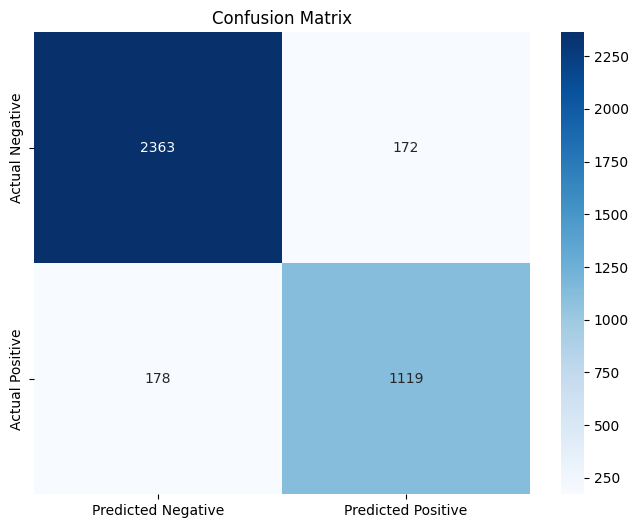

In [ ]:
Fdef main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Enhanced training configuration
    config = {
        'batch_size': 8,             # Maintained for better gradient estimates
        'learning_rate': 1e-5,        # Slightly reduced for stability
        'num_epochs': 20,             # Increased epochs for deeper convergence
        'warmup_ratio': 0.15,         # Extended warmup to 15%

    # Advanced Class Imbalance Handling
        'class_weights': {
              'NFV': {0: 1.0, 1: 10.0},
              'SQV': {0: 1.0, 1: 10.0},
              'IDV': {0: 1.0, 1: 9.0},
              'FPV': {0: 1.0, 1: 9.0},
              'ATV': {0: 1.0, 1: 9.0},
              'LPV': {0: 1.0, 1: 9.0},
              'TPV': {0: 1.0, 1: 15.0},   # Extreme imbalance
              'DRV': {0: 1.0, 1: 12.0}    # High imbalance
    },

    # Enhanced Loss Function
        'loss_type': 'focal_loss',
        'focal_gamma': 3.5,           # Refined focal loss parameter
        'focal_alpha': 0.75,          # Maintained alpha for class balance

    # Comprehensive Regularization
        'weight_decay': 0.015,        # Slightly increased
        'dropout_rate': 0.35,         # Increased dropout
        'label_smoothing': 0.15,      # Enhanced label smoothing

    # Advanced Training Optimizations
        'gradient_accumulation_steps': 4,
        'max_grad_norm': 1.2,         # Slight increase in gradient clipping
        'scheduler': 'triangular_with_warmup',  # More dynamic learning rate

    # Sophisticated Early Stopping
        'patience': 7,                # Extended patience
        'monitor_metric': 'recall',   # Maintained focus on recall

    # Enhanced Data Augmentation
        'augmentation': {
            'enable': True,
            'synonym_replacement_prob': 0.4,    # Increased probability
            'backtranslation_prob': 0.3,        # Enhanced probability
            'random_swap_prob': 0.2,            # Increased swap probability
            'noise_injection_prob': 0.2,        # Added noise injection
            'contextual_augment_prob': 0.1      # New contextual augmentation
        },

    # Additional Regularization Techniques
        'l1_regularization': 0.001,   # Added L1 regularization

    # Ensemble Preparation
        'ensemble_strategy': {
            'enable': True,
            'models_to_ensemble': 3,
            'aggregation_method': 'weighted_vote'
        }
    }

    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    model = AutoModelForSequenceClassification.from_pretrained(
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        num_labels=8,
        problem_type="multi_label_classification"
    ).to(device)

    # Add dropout for regularization
    model.dropout = torch.nn.Dropout(0.3)

    df = upload_and_process_file()
    sequences, labels = process_resistance_data(df)

    # Stratified split to handle imbalanced data
    X_train, X_val, y_train, y_val = train_test_split(
        sequences, labels,
        test_size=0.2,
        random_state=42
    )

    train_dataset = HIVDrugResistanceDataset(X_train, y_train, tokenizer)
    val_dataset = HIVDrugResistanceDataset(X_val, y_val, tokenizer)

    model, training_stats = train_model(train_dataset, val_dataset, model, device, config)
    return model, training_stats

if __name__ == "__main__":
    main()